In [95]:
from pandas import Series
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.under_sampling import RandomUnderSampler


from sklearn.preprocessing import RobustScaler, FunctionTransformer


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import recall_score, precision_score, f1_score, log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import PolynomialFeatures


import warnings

In [96]:
warnings.filterwarnings("ignore")  # Убирает некритические сообщения
RANDOM_SEED = 42
!pip freeze > requirements.txt

In [97]:
#для даты
def fill_season(data_season):
  if (data_season.month==6)|(data_season.month==7)|(data_season.month==8):
    return 2
  elif (data_season.month==9)|(data_season.month==10)|(data_season.month==11):
    return 3
  elif (data_season.month==12)|(data_season.month==1)|(data_season.month==2):
    return 4
  else:
    return 1

#num_cols.append('app_date_timedelta')
# Таблица метрик для сравнения результатов каждой модели
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'ROC_AUC']
summary = pd.DataFrame(index=metrics)


def summary_metrics(summary, col, y_valid, y_pred, y_pred_probs):
    values = [accuracy_score(y_valid, y_pred), precision_score(y_valid, y_pred), recall_score(
        y_valid, y_pred), f1_score(y_valid, y_pred), roc_auc_score(y_valid, y_pred_probs)]
    summary[col] = values
    return summary

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
#print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
# кривая ROC_AUC


def roc_auc_curve(y_valid, y_pred_probs):
    fpr, tpr, threshold = roc_curve(y_valid, y_pred_probs)
    roc_auc = roc_auc_score(y_valid, y_pred_probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label='Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# Confusion matrix


def conf_mat(y_valid, y_pred):
    P = np.sum(y_valid == 1)
    N = np.sum(y_valid == 0)
    print('Positive: {0}, Negative: {1}'.format(P, N))

    # tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
    # print(tp, fp)
    # print(fn, tn)

    cm = confusion_matrix(y_valid, y_pred)
    print(cm)
    # визуализация confusion matrix
    sns.set_context(context='paper', font_scale=2, rc=None)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cm.flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in
              zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

def plot_cv_metrics(cv_metrics):
    avg_f1_train, std_f1_train = cv_metrics['train_score'].mean(), cv_metrics['train_score'].std()
    avg_f1_valid, std_f1_valid = cv_metrics['test_score'].mean(), cv_metrics['test_score'].std()
    print('[train] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_train, std_f1_train))
    print('[valid] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_valid, std_f1_valid))
    
    plt.figure(figsize=(15, 5))

    plt.plot(cv_metrics['train_score'], label='train', marker='.')
    plt.plot(cv_metrics['test_score'], label='valid', marker='.')

    plt.ylim([0., 1.]);
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('F1-score', fontsize=15)
    plt.legend(fontsize=15)


def hist_vis(cols):
    for col in cols:
        fig = plt.figure()
        axes = fig.add_axes([0, 0, 1, 1])
        #fg_color = 'white'
        bank_data[col].hist()
        # set tick and ticklabel color цифры на осях
        #axes.tick_params(color=fg_color, labelcolor=fg_color)
        #plt.title(col, color='w')
        plt.title(col)

        plt.show()
        
def hist_health(col):
    median = col.median()
    IQR = col.quantile(0.75) - col.quantile(0.25)
    min_ = col.min()
    max_ = col.max()
    
    print(median, IQR, median - 1.5*IQR, median + 1.5*IQR)
    
    col.loc[col.between(
    median - 1.5*IQR, median + 1.5*IQR)].hist(bins=100, range=(min_, max_), label='IQR')
    col.loc[col <= max_].hist(
        alpha=0.5, bins=100, range=(min_, max_), label='Здравый смысл')
    plt.legend()
    

In [98]:
#Код, который выполнять не нужно
%%script false


from google.colab import drive
drive.mount('/content/drive')
#vis_data = pd.read_csv("./train.csv", encoding = 'ISO-8859-1', low_memory = False)
#bank_data = pd.read_csv('drive/My Drive/Colab Notebooks/Project_5/train.csv', encoding = 'ISO-8859-1', low_memory = False)
df_train = pd.read_csv('drive/My Drive/Colab Notebooks/Project_5/train.csv', encoding = 'ISO-8859-1', low_memory = False)
df_test = pd.read_csv('drive/My Drive/Colab Notebooks/Project_5/test.csv', encoding = 'ISO-8859-1', low_memory = False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
#Код, который выполнять не нужно
#%%script false
df_train = pd.read_csv('Project_5/train.csv', encoding = 'ISO-8859-1', low_memory = False)
df_test = pd.read_csv('Project_5/test.csv', encoding = 'ISO-8859-1', low_memory = False)

In [100]:
#объединим трейн и тест в один датасет для того, чтобы обработать признаки

df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения default, мы его должны предсказать, по этому пока просто заполняем нулями

bank_data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [101]:
display(bank_data)
print(bank_data.shape)
print(bank_data.isna().sum())
print(bank_data.info())

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,04MAR2014,GRD,F,45,N,N,0,0,-1.792064,3,50,1,2,17000,4,4,N,1,0
110144,76821,24MAR2014,SCH,M,41,Y,Y,0,0,-2.058029,1,50,2,2,70000,1,4,N,1,0
110145,103695,22APR2014,SCH,M,31,N,N,0,0,-1.512635,4,80,2,3,45000,2,2,N,1,0
110146,861,04JAN2014,SCH,F,29,N,N,0,1,-1.479334,3,50,1,3,13000,2,3,N,1,1


(110148, 20)
client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 

In [102]:
bank_data.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'sample', 'default'],
      dtype='object')

In [103]:
# столбцы с количественными характеристиками 6
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki'] 
# столбцы с бинарными характеристиками 5
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
# столбцы с категориальными характеристиками 5
#cat_cols = ['education', 'work_address', 'home_address', 'sna', 'first_time', 'season', 'region_rating']
cat_cols = ['education', 'work_address', 'home_address', 'sna', 'first_time', 'region_rating']
#data
data_z = ['app_date']

In [104]:
display(bank_data.describe())
print(bank_data.describe(include = ['object']))

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,sample,default
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000
mean,55074.500000,39.249410,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,0.669999,0.085086
std,31797.133063,11.518063,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,0.470215,0.279010
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000,0.000000
25%,27537.750000,30.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000,0.000000
50%,55074.500000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,1.000000,0.000000
75%,82611.250000,48.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,1.000000,0.000000
max,110148.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000,1.000000


         app_date education     sex     car car_type foreign_passport
count      110148    109670  110148  110148   110148           110148
unique        120         5       2       2        2                2
top     18MAR2014       SCH       F       N        N                N
freq         1491     57998   61836   74290    89140            93721


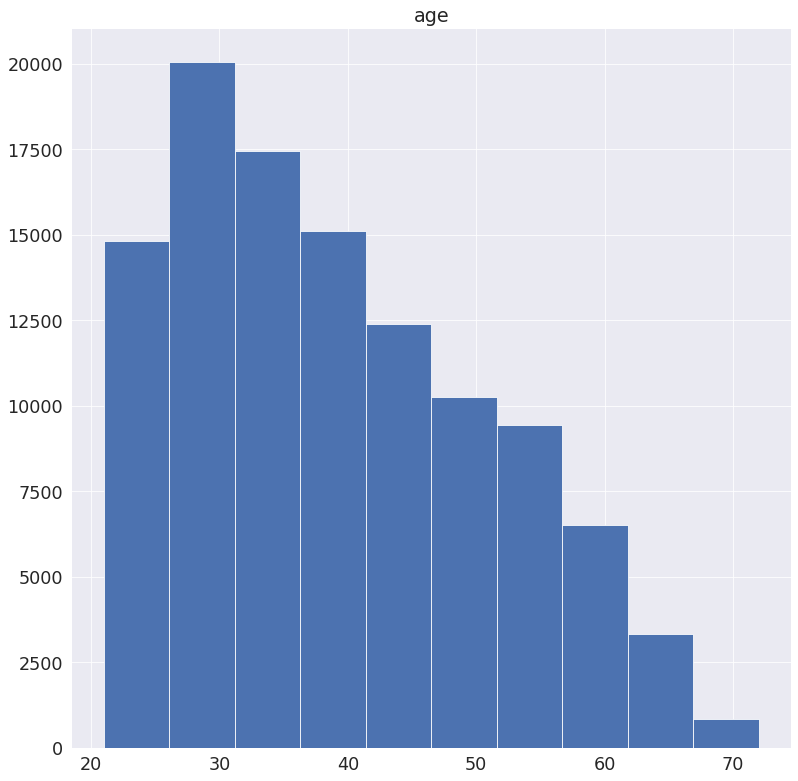

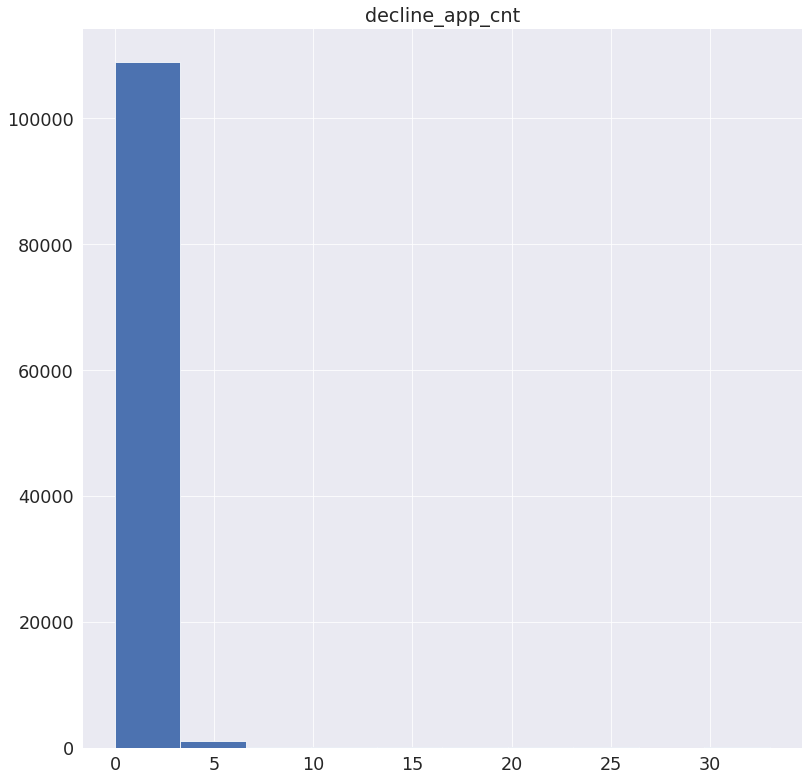

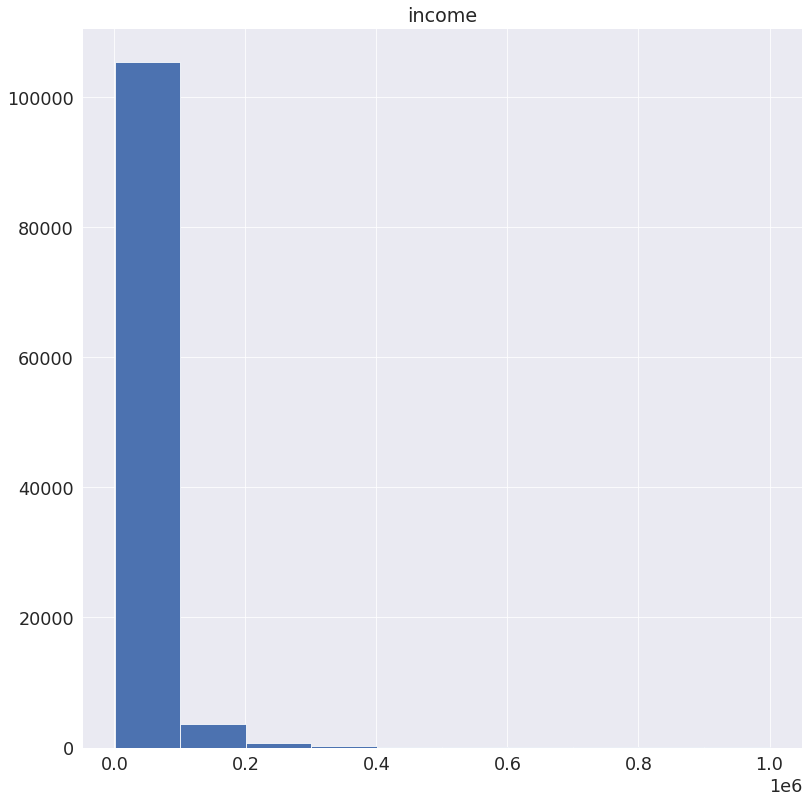

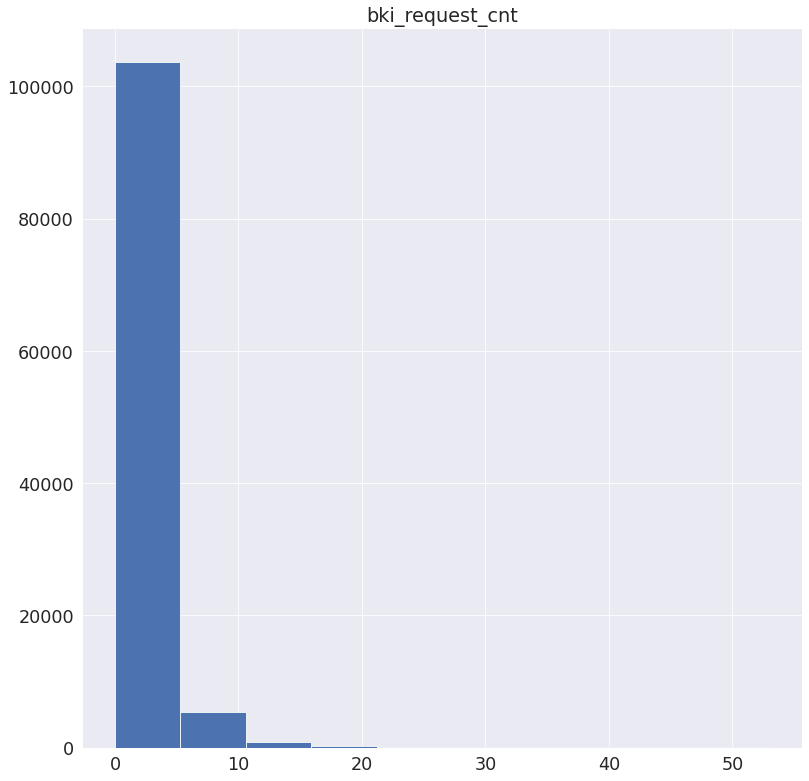

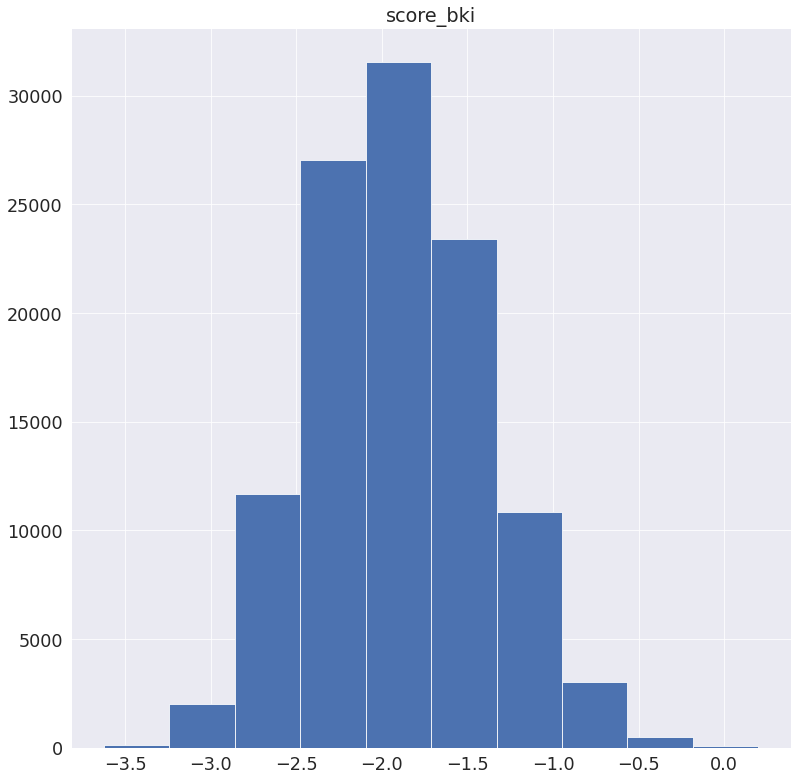

In [105]:
# начнем рассматривать данные подробнее
# сначала количественные характеристики
hist_vis(num_cols)


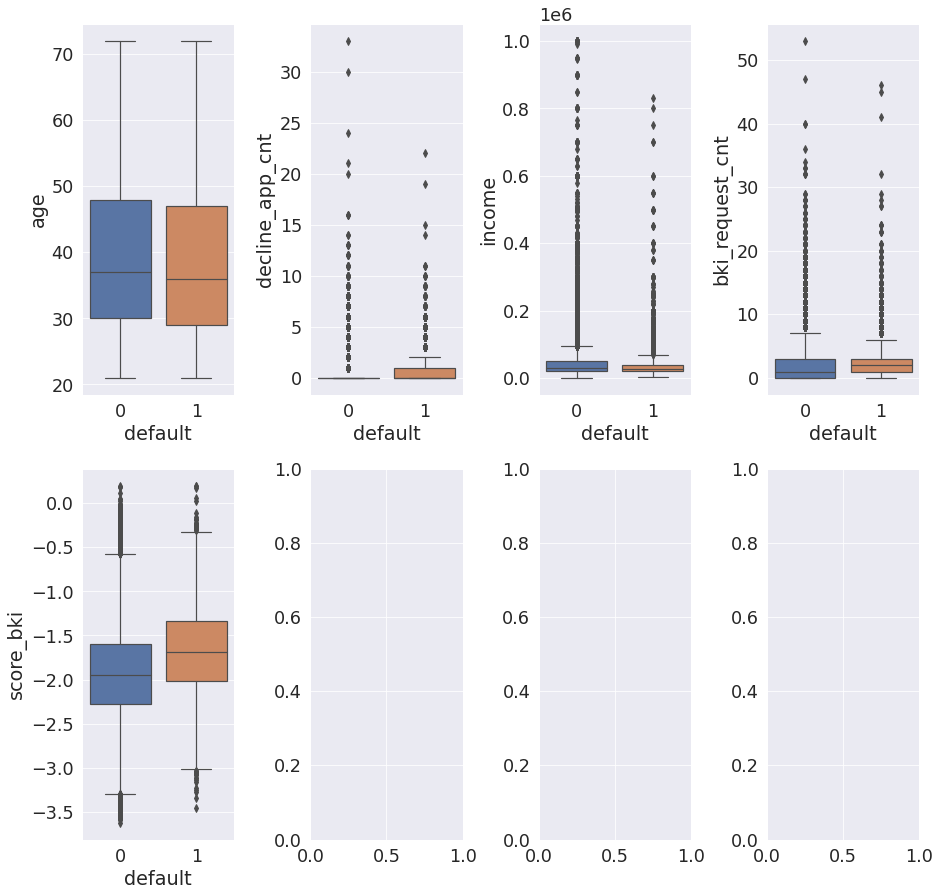

In [106]:
fig, axes = plt.subplots(2, 4, figsize=(15, 15))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()

for i in range(len(num_cols)):
    sns.boxplot(x='default', y=num_cols[i], data=bank_data,
                orient='v', ax=axes[i], showfliers=True)

In [107]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    bank_data[column] = label_encoder.fit_transform(bank_data[column])
    
# убедимся в преобразовании    
bank_data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,1,29,1,1,0,0,-2.271884,3,50,1,2,50000,1,4,0,0,0
1,17527,24JAN2014,SCH,0,39,0,0,5,0,-1.504999,2,50,1,2,5000,4,3,0,0,0
2,75683,23MAR2014,UGR,1,50,1,1,0,0,-1.691339,1,50,1,2,30000,1,3,1,0,0
3,26883,03FEB2014,SCH,1,56,0,0,0,0,-2.374182,1,40,1,2,17000,1,3,0,0,0
4,28862,04FEB2014,GRD,0,38,0,0,0,0,-2.487502,0,80,2,3,120000,1,3,0,0,0


In [108]:
#прологарифмируем количесвенные
num_cols_log = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']

for i in num_cols_log:
    bank_data[i] = np.log(bank_data[i] + 1)


In [109]:
bank_data.loc[(bank_data['education'].isnull()), 'education'] = 'SCH'                                                
bank_data['education'] = label_encoder.fit_transform(bank_data['education'])
bank_data['region_rating'] = label_encoder.fit_transform(bank_data['region_rating'])

#bank_data['app_date']=pd.to_datetime(bank_data['app_date'])
#bank_data['season'] = np.nan
#bank_data['season'] = bank_data['app_date'].apply(fill_season)
display(bank_data.head(5))

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,1,1,3.401197,1,1,0.000000,0,-2.271884,1.386294,3,1,2,10.819798,1,4,0,0,0
1,17527,24JAN2014,3,0,3.688879,0,0,1.791759,0,-1.504999,1.098612,3,1,2,8.517393,4,3,0,0,0
2,75683,23MAR2014,4,1,3.931826,1,1,0.000000,0,-1.691339,0.693147,3,1,2,10.308986,1,3,1,0,0
3,26883,03FEB2014,3,1,4.043051,0,0,0.000000,0,-2.374182,0.693147,2,1,2,9.741027,1,3,0,0,0
4,28862,04FEB2014,1,0,3.663562,0,0,0.000000,0,-2.487502,0.000000,6,2,3,11.695255,1,3,0,0,0


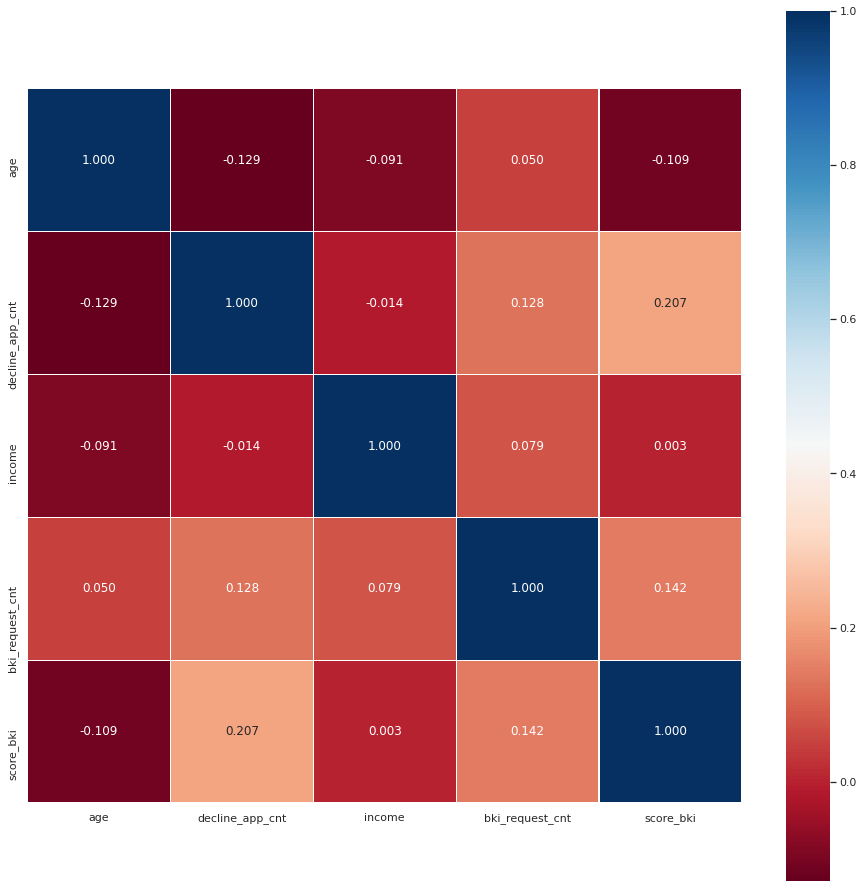

In [110]:
sns.set(font_scale=1)
plt.subplots(figsize=(16, 16))
sns.heatmap(bank_data[num_cols].corr(method='pearson'), square=True,
              annot=True, fmt=".3f", linewidths=0.3, cmap="RdBu")

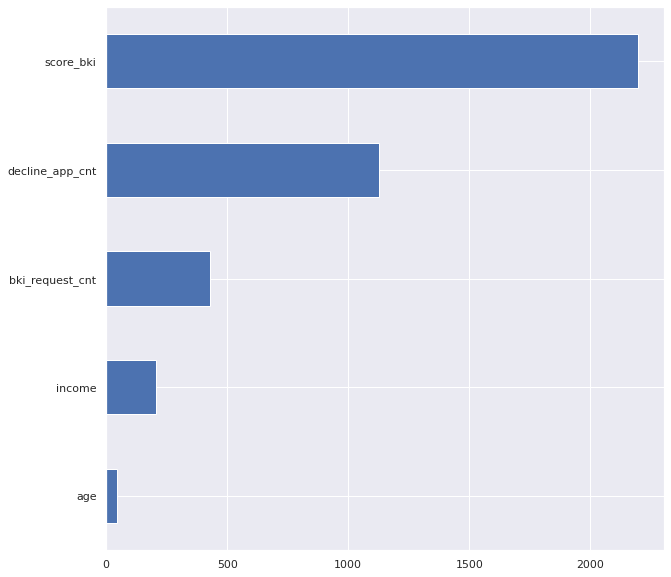

In [111]:
imp_num = Series(f_classif(bank_data[num_cols], bank_data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

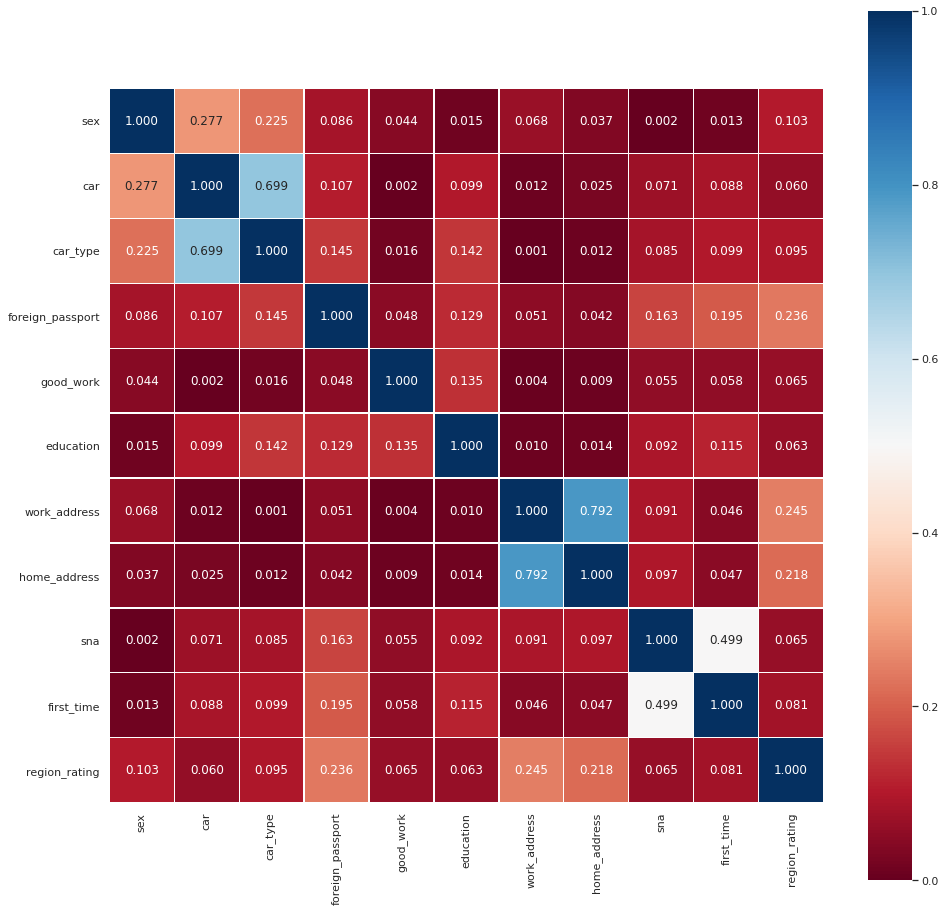

In [112]:
# оценим корреляцию Спирмана для нечисловых переменных
sns.set(font_scale=1)
plt.subplots(figsize=(16, 16))
sns.heatmap(bank_data[bin_cols + cat_cols].corr(method='spearman').abs(), square=True,
              annot=True, fmt=".3f", linewidths=0.3, cmap="RdBu", vmin=0, vmax=1)

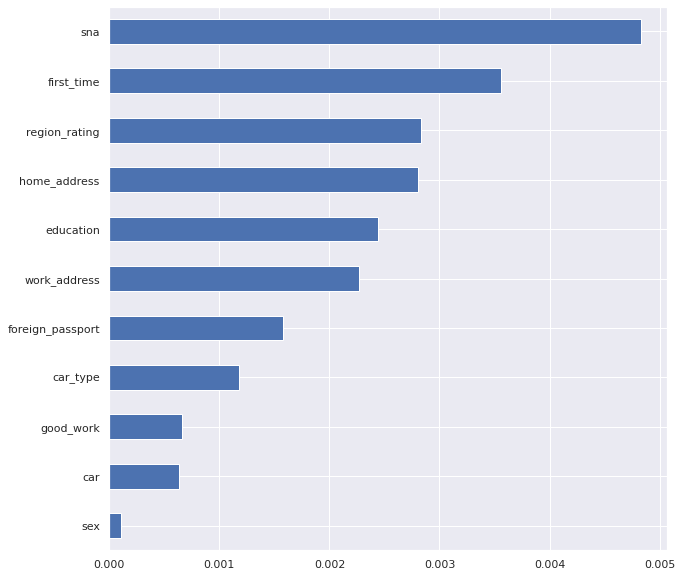

In [113]:
imp_cat = Series(mutual_info_classif(bank_data[bin_cols + cat_cols], bank_data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [114]:
# Стандартизация числовых переменных
ss = StandardScaler()
bank_data[num_cols] = pd.DataFrame(ss.fit_transform(bank_data[num_cols]),columns = bank_data[num_cols].columns)

In [115]:
display(bank_data)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,1,1,-0.888776,1,1,-0.418815,0,-0.735587,0.770563,3,1,2,0.680425,1,4,0,0,0
1,17527,24JAN2014,3,0,0.120447,0,0,4.539989,0,0.800039,0.333797,3,1,2,-2.624624,4,3,0,0,0
2,75683,23MAR2014,4,1,0.972731,1,1,-0.418815,0,0.426908,-0.281790,3,1,2,-0.052834,1,3,1,0,0
3,26883,03FEB2014,3,1,1.362924,0,0,-0.418815,0,-0.940432,-0.281790,2,1,2,-0.868125,1,3,0,0,0
4,28862,04FEB2014,1,0,0.031629,0,0,-0.418815,0,-1.167347,-1.334144,6,2,3,1.937123,1,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,04MAR2014,1,0,0.610749,0,0,-0.418815,0,0.225214,0.770563,3,1,2,-0.868125,4,4,0,1,0
110144,76821,24MAR2014,3,1,0.291609,1,1,-0.418815,0,-0.307360,-0.281790,3,2,2,1.163415,1,4,0,1,0
110145,103695,22APR2014,3,1,-0.662367,0,0,-0.418815,0,0.784750,1.109345,6,2,3,0.529186,2,2,0,1,0
110146,861,04JAN2014,3,0,-0.888776,0,0,-0.418815,1,0.851432,0.770563,3,1,3,-1.253186,2,3,0,1,1


In [116]:
# Encoding categorical variables.
bank_data = pd.get_dummies(bank_data, prefix=cat_cols, columns=cat_cols)
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 40 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   sex               110148 non-null  int64  
 3   age               110148 non-null  float64
 4   car               110148 non-null  int64  
 5   car_type          110148 non-null  int64  
 6   decline_app_cnt   110148 non-null  float64
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  float64
 10  income            110148 non-null  float64
 11  foreign_passport  110148 non-null  int64  
 12  sample            110148 non-null  int64  
 13  default           110148 non-null  int64  
 14  education_0       110148 non-null  uint8  
 15  education_1       110148 non-null  uint8  
 16  education_2       11

Text(0, 0.5, 'Число заемщиков')

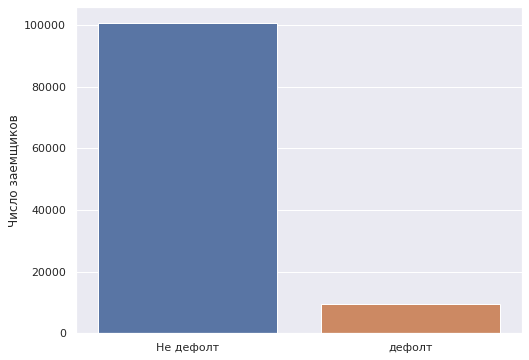

In [117]:
#ассмотрим как сбалансирована выборка относительно целевой веременной
pos = bank_data[bank_data["default"] == 1].shape[0]
neg = bank_data[bank_data["default"] == 0].shape[0]
plt.figure(figsize=(8, 6))
sns.countplot(bank_data["default"])
plt.xticks((0, 1), ["Не дефолт", "дефолт"])
plt.xlabel("")
plt.ylabel("Число заемщиков")

Полученная диаграмма показывает, что выборка не сбалансирована относительно целевой переменной

In [118]:
# Splitting the dataset.# разделим снова на train_df и test_df
train_data = bank_data.query('sample == 1').drop(['sample', 'client_id', 'app_date'], axis=1)
test_data = bank_data.query('sample == 0').drop(['sample', 'client_id', 'app_date'], axis=1)

In [119]:
display(train_data)

,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,foreign_passport,default,education_0,education_1,education_2,education_3,education_4,work_address_1,work_address_2,work_address_3,home_address_1,home_address_2,home_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,region_rating_0,region_rating_1,region_rating_2,region_rating_3,region_rating_4,region_rating_5,region_rating_6
36349,1,1.714029,1,1,-0.418815,0,-0.208688,-0.281790,-0.786080,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0
36350,0,1.542867,0,0,-0.418815,0,0.745419,0.770563,-0.708472,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0
36351,1,-1.390791,1,0,2.621662,0,0.993988,-0.281790,-0.052834,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
36352,0,1.173250,0,0,-0.418815,0,-0.306243,0.333797,-1.629771,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
36353,1,0.832388,0,0,-0.418815,1,1.321223,-0.281790,-0.052834,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,0,0.610749,0,0,-0.418815,0,0.225214,0.770563,-0.868125,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
110144,1,0.291609,1,1,-0.418815,0,-0.307360,-0.281790,1.163415,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0
110145,1,-0.662367,0,0,-0.418815,0,0.784750,1.109345,0.529186,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
110146,0,-0.888776,0,0,-0.418815,1,0.851432,0.770563,-1.253186,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0


In [120]:
display(test_data)

,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,foreign_passport,default,education_0,education_1,education_2,education_3,education_4,work_address_1,work_address_2,work_address_3,home_address_1,home_address_2,home_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,region_rating_0,region_rating_1,region_rating_2,region_rating_3,region_rating_4,region_rating_5,region_rating_6
0,1,-0.888776,1,1,-0.418815,0,-0.735587,0.770563,0.680425,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,0,0.120447,0,0,4.539989,0,0.800039,0.333797,-2.624624,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
2,1,0.972731,1,1,-0.418815,0,0.426908,-0.281790,-0.052834,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
3,1,1.362924,0,0,-0.418815,0,-0.940432,-0.281790,-0.868125,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,0,0.031629,0,0,-0.418815,0,-1.167347,-1.334144,1.937123,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36344,0,-0.059496,0,0,1.499512,0,0.319505,0.770563,-1.047783,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0
36345,0,1.823666,1,1,-0.418815,0,-0.779436,0.770563,2.670397,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
36346,1,-0.662367,0,0,2.621662,0,1.929901,-0.281790,0.942139,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
36347,0,-1.130811,0,0,1.499512,0,1.325890,0.333797,-0.052834,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [121]:

X = train_data.drop(['default'], axis=1)
Y = train_data['default'].values

In [122]:
#Код, который выполнять не нужно
%%script false 
#bank_data = bank_data.drop(['client_id','app_date','work_address','car'], axis=1)
# разделим снова на train_df и test_df
train_data = bank_data[bank_data['sample']== 1].drop(['sample'], axis=1)
test_data = bank_data[bank_data['sample']== 0].drop(['sample'], axis=1)
display(train_data.head(2))

In [123]:
#Код, который выполнять не нужно
%%script false
X_cat = OneHotEncoder(sparse = False).fit_transform(train_data[cat_cols].values)
print(X_cat.shape)

# Стандартизация числовых переменных
X_num = StandardScaler().fit_transform(train_data[num_cols].values)

# Объединяем
X = np.hstack([X_num, train_data[bin_cols].values, X_cat])
Y = train_data['default'].values
print(X)
print(X.shape)


In [124]:
#Разделим данные для обучения следующим образом
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

model_0 = LogisticRegression()
model_0.fit(X_train, y_train)
#обучили
Y_predicted = model_0.predict(X_test)

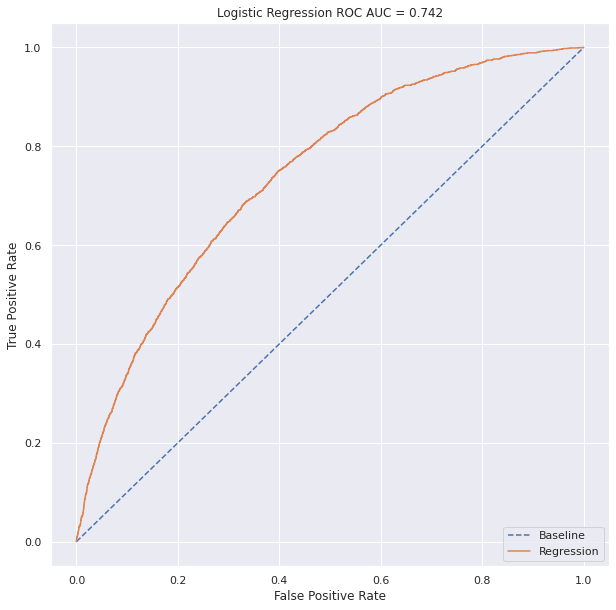

Positive: 1827, Negative: 12933
[[12882    51]
 [ 1786    41]]


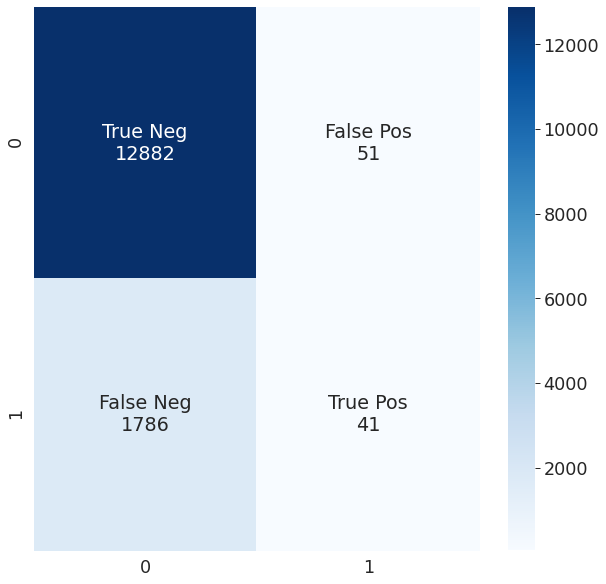

In [125]:
probs = model_0.predict_proba(X_test)
y_pred_probs = probs[:,1]

#выводим ROC AUC
roc_auc_curve(y_test, y_pred_probs)

#выводим confusion matrix
conf_mat(y_test, Y_predicted)


In [126]:
# сравним метрики с предыдущей моделью
summary_metrics(summary,'model_0',y_test,Y_predicted,y_pred_probs)

,model_0
accuracy,0.875542
precision,0.445652
recall,0.022441
f1_score,0.042731
ROC_AUC,0.741925


[train] F1-score = 0.74 +/- 0.00
[valid] F1-score = 0.74 +/- 0.02


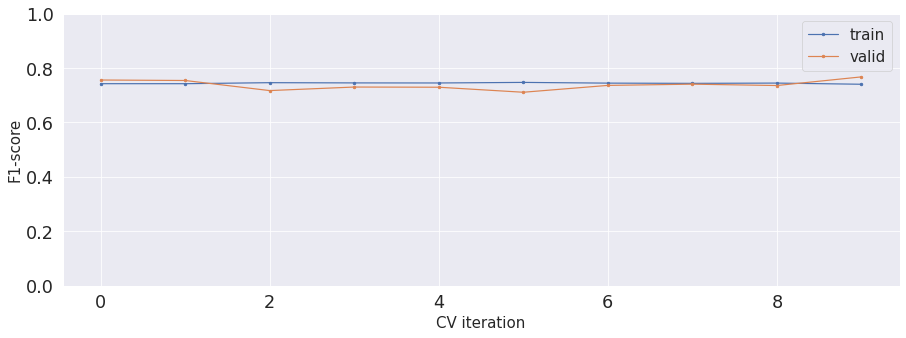

In [127]:
temp_vec = cross_validate(model_0, X_test, y_test, cv=10, scoring='roc_auc', return_train_score=True)
plot_cv_metrics(temp_vec)

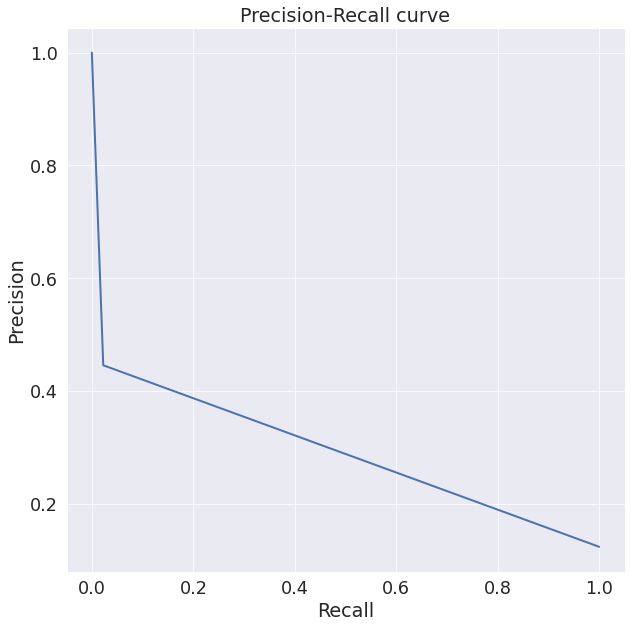

In [128]:
precisions, recalls, thresholds = precision_recall_curve(y_test, Y_predicted)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(recalls, precisions, linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.savefig("Precision_Recall_curve.png")
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()


In [129]:
report = classification_report(y_test, Y_predicted, target_names=['Negative', 'Positive'])
print(report)

              precision    recall  f1-score   support

    Negative       0.88      1.00      0.93     12933
    Positive       0.45      0.02      0.04      1827

    accuracy                           0.88     14760
   macro avg       0.66      0.51      0.49     14760
weighted avg       0.82      0.88      0.82     14760



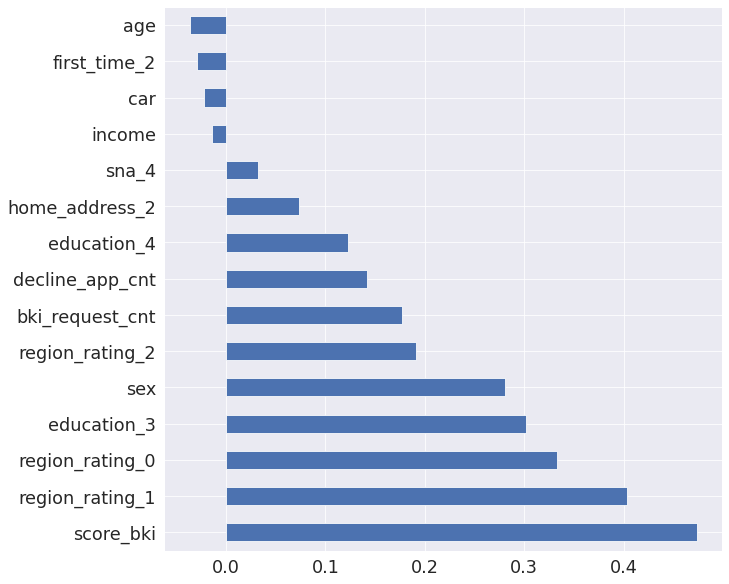

In [130]:
# выводим самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model_0.coef_.flatten(), index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [131]:
#подберем гиперпараметры
#model = LogisticRegression(random_state=42)
param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}, 
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}, 
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}
     ]
gridsearch = GridSearchCV(model_0, param_grid, scoring='recall', n_jobs=-1)
gridsearch.fit(X_train, y_train)
model_0 = gridsearch.best_estimator_
## печатаем параметры
best_parameters = model_0.get_params()
# View best hyperparameters
print(f'Лучшие значения параметров:') 
for param_name in best_parameters.keys():
        print(f'  {param_name} = {best_parameters[param_name]},')

Лучшие значения параметров:
  C = 1.0,
  class_weight = balanced,
  dual = False,
  fit_intercept = True,
  intercept_scaling = 1,
  l1_ratio = None,
  max_iter = 100,
  multi_class = auto,
  n_jobs = None,
  penalty = none,
  random_state = None,
  solver = newton-cg,
  tol = 0.0001,
  verbose = 0,
  warm_start = False,


In [132]:
# Разобьем данные для обучения и тестирования по новой
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [133]:
# строим модель
new_model_0 = LogisticRegression(random_state = None, 
                               C = 1.0, 
                               class_weight = 'balanced', 
                               dual = False, 
                               fit_intercept = True, 
                               intercept_scaling = 1, 
                               l1_ratio = None, 
                               max_iter = 100, 
                               multi_class = 'auto', 
                               n_jobs = None, 
                               penalty = 'none', 
                               solver = 'newton-cg', 
                               tol = 0.0001,
                               verbose = 0, 
                               warm_start = False)
new_model_0.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='none', random_state=None, solver='newton-cg',
                   tol=0.0001, verbose=0, warm_start=False)

In [134]:
#обучили
Y_predicted = new_model_0.predict(X_test)

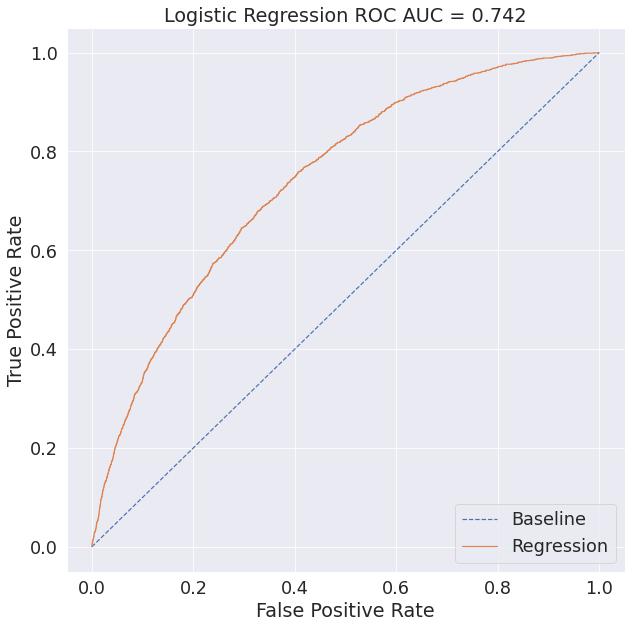

Positive: 1827, Negative: 12933
[[8569 4364]
 [ 570 1257]]


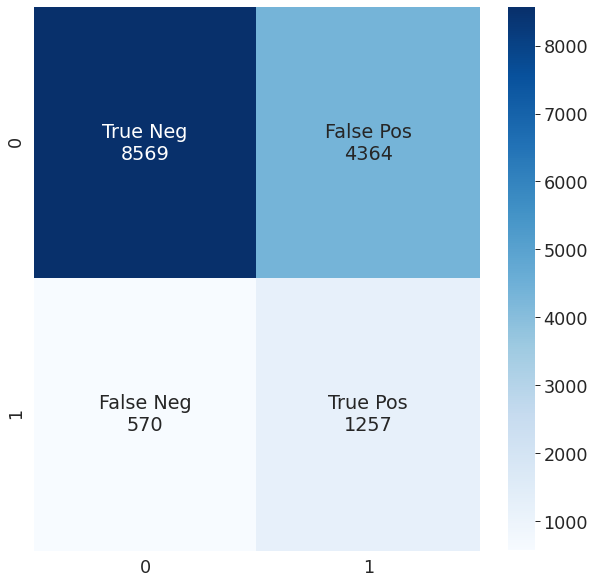

In [135]:
probs = new_model_0.predict_proba(X_test)
y_pred_probs = probs[:,1]

#выводим ROC AUC
roc_auc_curve(y_test, y_pred_probs)

#выводим confusion matrix
conf_mat(y_test, Y_predicted)



In [136]:
# сравним метрики с предыдущей моделью
summary_metrics(summary,'new_model_0',y_test,Y_predicted,y_pred_probs)

,model_0,new_model_0
accuracy,0.875542,0.665718
precision,0.445652,0.223626
recall,0.022441,0.688013
f1_score,0.042731,0.337540
ROC_AUC,0.741925,0.741504


[train] F1-score = 0.74 +/- 0.00
[valid] F1-score = 0.74 +/- 0.02


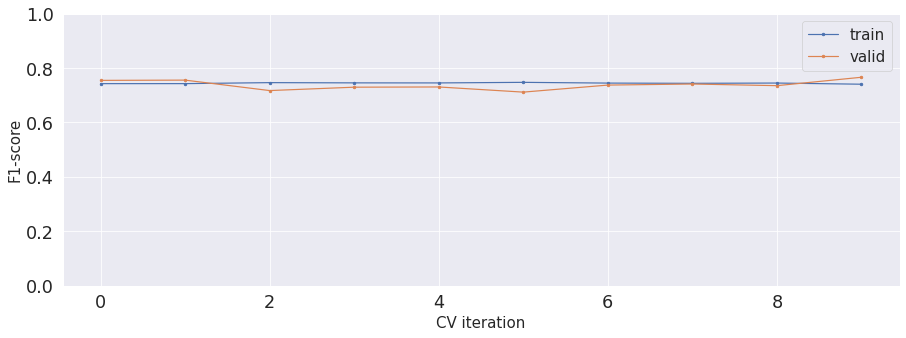

In [137]:
temp_vec = cross_validate(new_model_0, X_test, y_test, cv=10, scoring='roc_auc', return_train_score=True)
plot_cv_metrics(temp_vec)

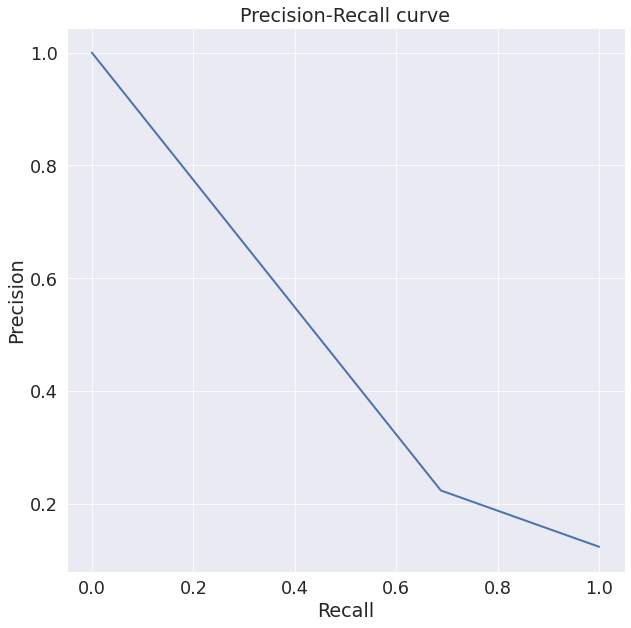

In [138]:
precisions, recalls, thresholds = precision_recall_curve(y_test, Y_predicted)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(recalls, precisions, linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.savefig("Precision_Recall_curve.png")
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [139]:
report = classification_report(y_test, Y_predicted, target_names=['Negative', 'Positive'])
print(report)

              precision    recall  f1-score   support

    Negative       0.94      0.66      0.78     12933
    Positive       0.22      0.69      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.68      0.56     14760
weighted avg       0.85      0.67      0.72     14760



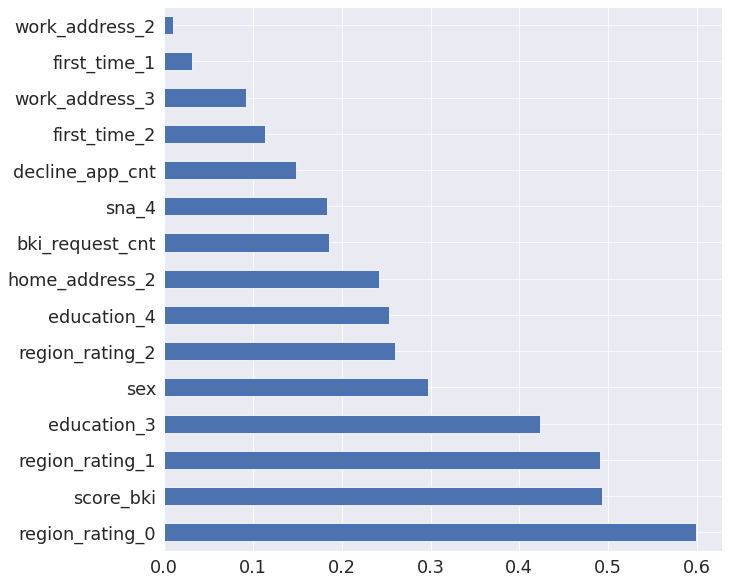

In [140]:
#result = model_0.coef_.flatten()
#ывести самые важные признаки для модели
#plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(new_model_0.coef_.flatten(), index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')


In [142]:
#применим under_sampling для равенства классов
from imblearn.under_sampling import RandomUnderSampler


rus = RandomUnderSampler(random_state=42)
X_us, y_us = rus.fit_resample(X, Y)

X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(X_us, y_us, test_size=0.20, shuffle = True, random_state=RANDOM_SEED)
#model_us = LogisticRegression()
#model_us.fit(X_train_us, y_train_us)
model_us_0 = LogisticRegression()

model_us_0.fit(X_train_us, y_train_us)

probs = model_us_0.predict_proba(X_test_us)
y_pred_probs = probs[:,1]

Y_predicted = model_us_0.predict(X_test_us)

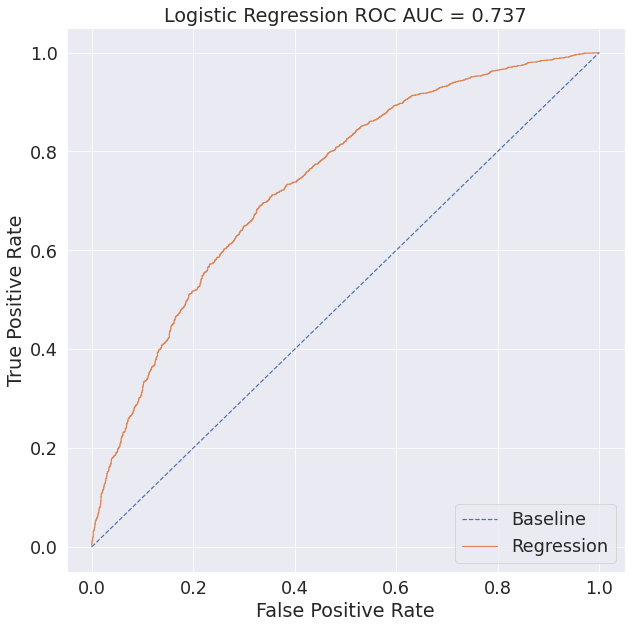

Positive: 1862, Negative: 1887
[[1257  630]
 [ 575 1287]]


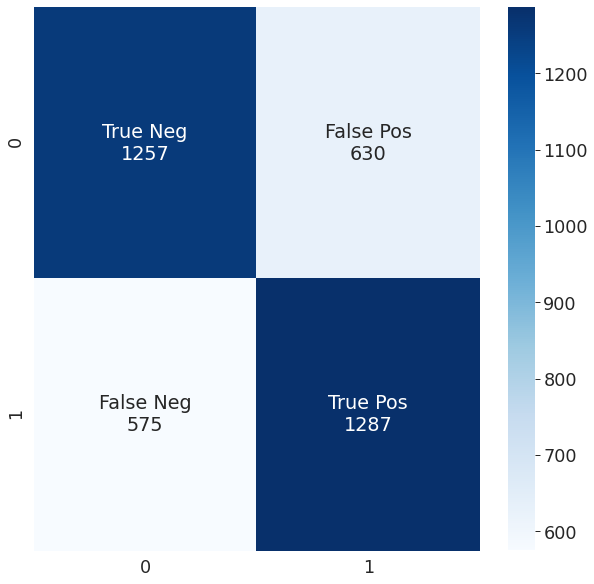

In [143]:
roc_auc_curve(y_test_us, y_pred_probs)


# confusion matrix
P = np.sum(y_test_us == 1)
N = np.sum(y_test_us == 0)
print('Positive: {0}, Negative: {1}'.format(P, N))

cm = confusion_matrix(y_test_us, Y_predicted)
print(cm)

# визуализация confusion matrix
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

In [144]:
# сравним метрики с предыдущей моделью
summary_metrics(summary,'model_us_0',y_test_us,Y_predicted,y_pred_probs)

,model_0,new_model_0,model_us_0
accuracy,0.875542,0.665718,0.678581
precision,0.445652,0.223626,0.671362
recall,0.022441,0.688013,0.691192
f1_score,0.042731,0.337540,0.681133
ROC_AUC,0.741925,0.741504,0.737270


[train] F1-score = 0.74 +/- 0.00
[valid] F1-score = 0.73 +/- 0.03


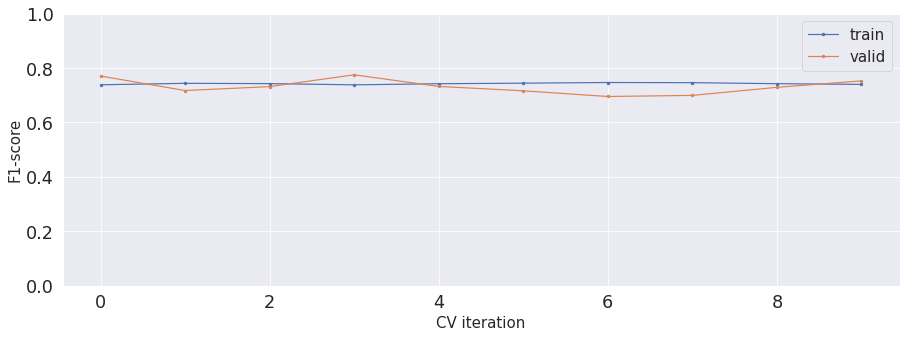

In [145]:
temp_vec = cross_validate(model_us_0, X_test_us, y_test_us, cv=10, scoring='roc_auc', return_train_score=True)
plot_cv_metrics(temp_vec)

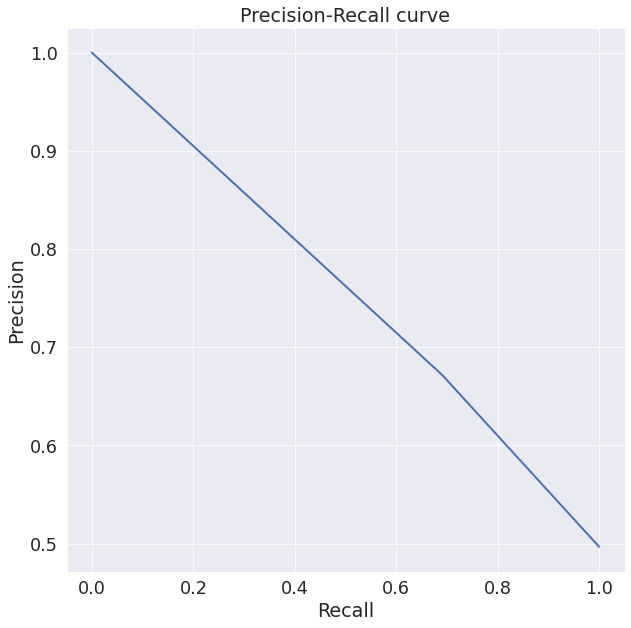

In [146]:
precisions, recalls, thresholds = precision_recall_curve(y_test_us, Y_predicted)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(recalls, precisions, linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.savefig("Precision_Recall_curve.png")
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [147]:
report = classification_report(y_test_us, Y_predicted, target_names=['Negative', 'Positive'])
print(report)

              precision    recall  f1-score   support

    Negative       0.69      0.67      0.68      1887
    Positive       0.67      0.69      0.68      1862

    accuracy                           0.68      3749
   macro avg       0.68      0.68      0.68      3749
weighted avg       0.68      0.68      0.68      3749



In [ ]:
# imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
# resampled_rf = BalancedBaggingClassifier(base_estimator=new_model_0,
#                                          n_estimators=10,
#                                          random_state=0)
# pip_resampled = make_pipeline(imputer,
#                               RobustScaler(),
#                               resampled_rf)
# scores = cross_val_score(pip_resampled,
#                          X_train, y_train,
#                          scoring="roc_auc", cv=10)

# print("AUC модели EasyEnsemble: ", scores.mean())
#показатели хуже

AUC модели EasyEnsemble:  0.7289299031117551


Точно закончили


++++++++++++++++++++++

In [148]:
#Код, который выполнять не нужно
%%script false
#'main_task.csv'
#подгрузим данные заново
from google.colab import drive
drive.mount('/content/drive')
#vis_data = pd.read_csv("./train.csv", encoding = 'ISO-8859-1', low_memory = False)
#bank_data = pd.read_csv('drive/My Drive/Colab Notebooks/Project_5/train.csv', encoding = 'ISO-8859-1', low_memory = False)
df_train = pd.read_csv('drive/My Drive/Colab Notebooks/Project_5/train.csv', encoding = 'ISO-8859-1', low_memory = False)
df_test = pd.read_csv('drive/My Drive/Colab Notebooks/Project_5/test.csv', encoding = 'ISO-8859-1', low_memory = False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Код, который выполнять не нужно
#%%script false
df_train = pd.read_csv('Project_5/train.csv', encoding = 'ISO-8859-1', low_memory = False)
df_test = pd.read_csv('Project_5/test.csv', encoding = 'ISO-8859-1', low_memory = False)

In [149]:
#объединим трейн и тест в один датасет для того, чтобы обработать признаки

df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения default, мы его должны предсказать, по этому пока просто заполняем нулями

bank_data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

-1.92082293 0.6925455175000004 -2.9596412062500006 -0.8820046537499993


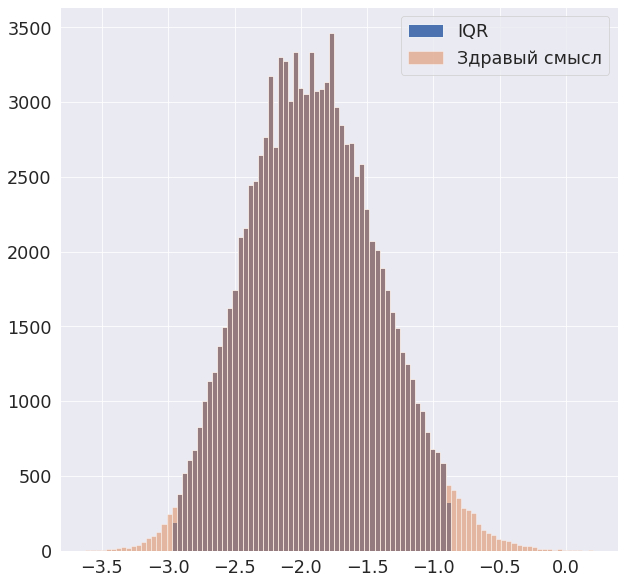

In [150]:
hist_health(bank_data.score_bki)

1.0 3.0 -3.5 5.5


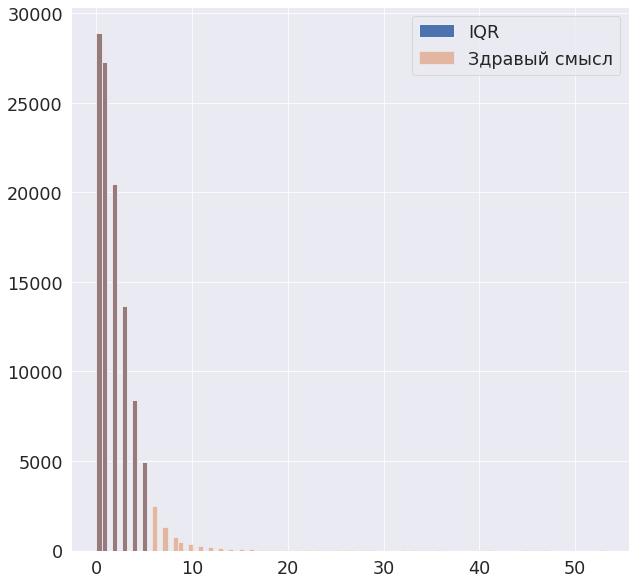

In [151]:
hist_health(bank_data.bki_request_cnt)

0.0 0.0 0.0 0.0


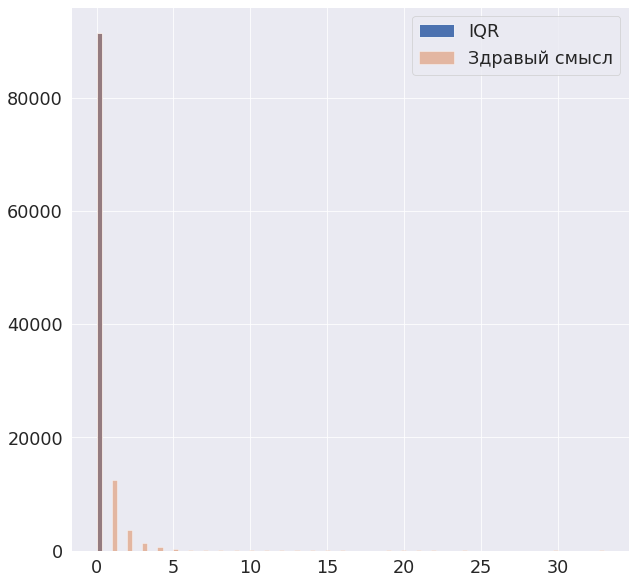

In [152]:
hist_health(bank_data.decline_app_cnt)

30000.0 28000.0 -12000.0 72000.0


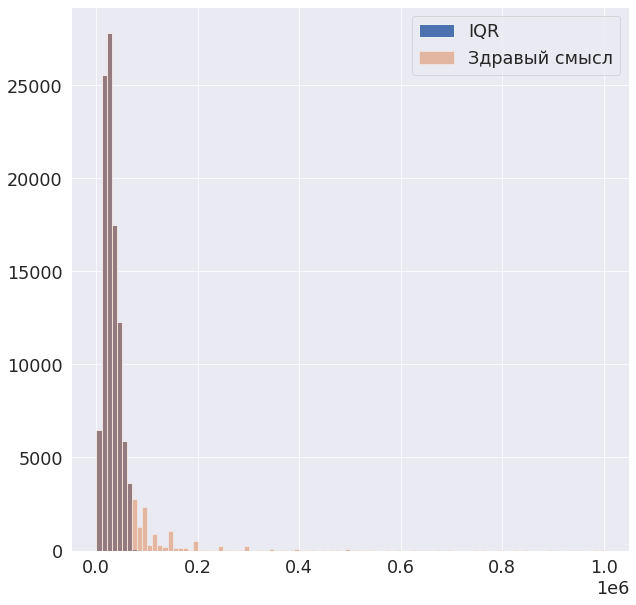

In [153]:
hist_health(bank_data.income)

In [154]:
bank_data.loc[(bank_data['bki_request_cnt'] > 9), 'bki_request_cnt'] = 10
bank_data.loc[(bank_data['decline_app_cnt'] > 4), 'decline_app_cnt'] = 5
bank_data.loc[(bank_data['score_bki'] < -2.959641), 'score_bki'] = -2.960000
bank_data.loc[(bank_data['score_bki'] > -0.882004), 'score_bki'] = -0.890000
#руководствуясь "здравым смыслом" предлагаю все что больше 100000 - заменить на допустим 100000
bank_data.loc[(bank_data['income'] >= 100000), 'income'] = 100000

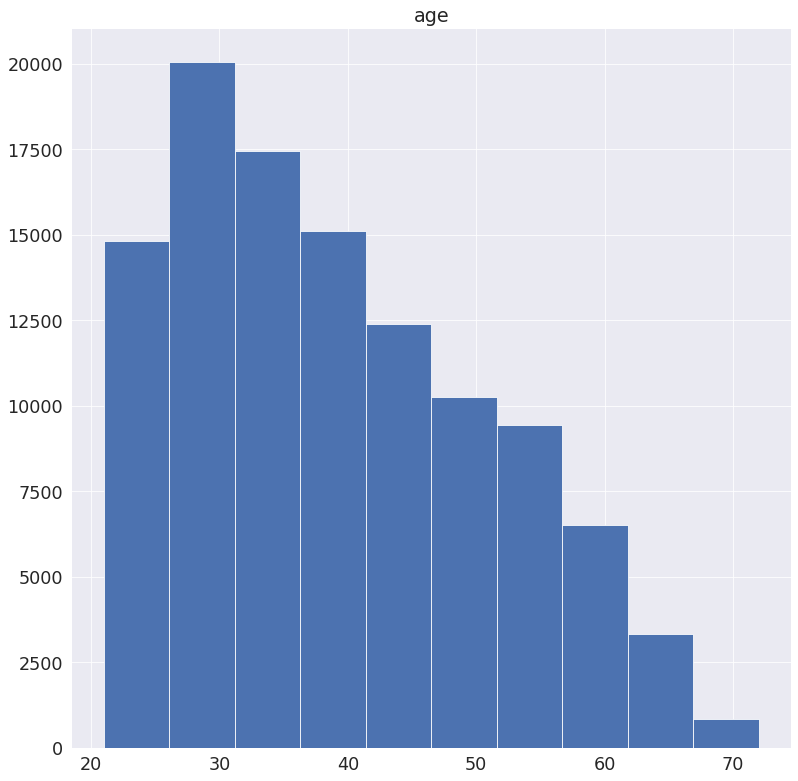

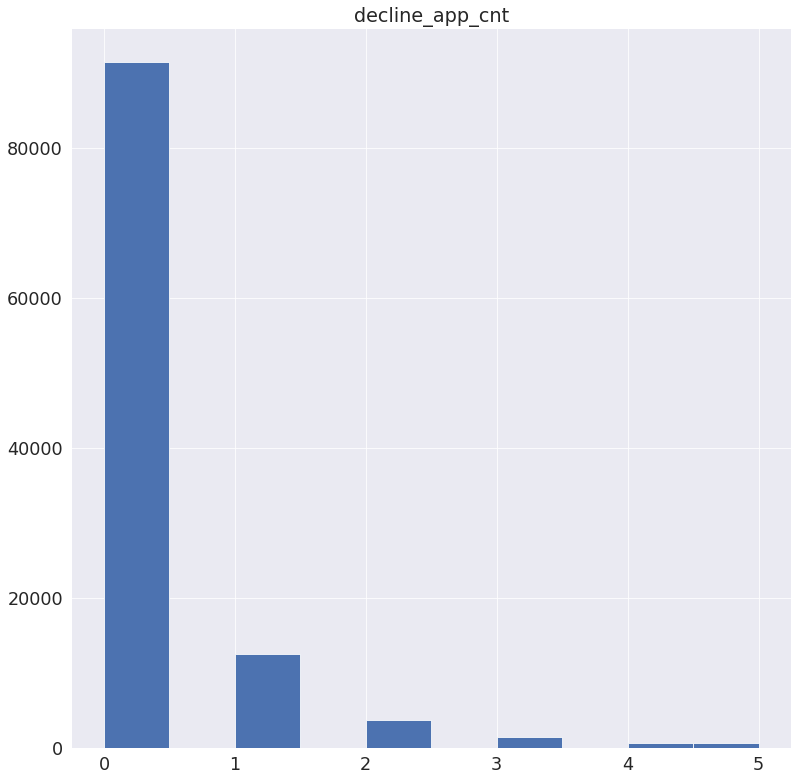

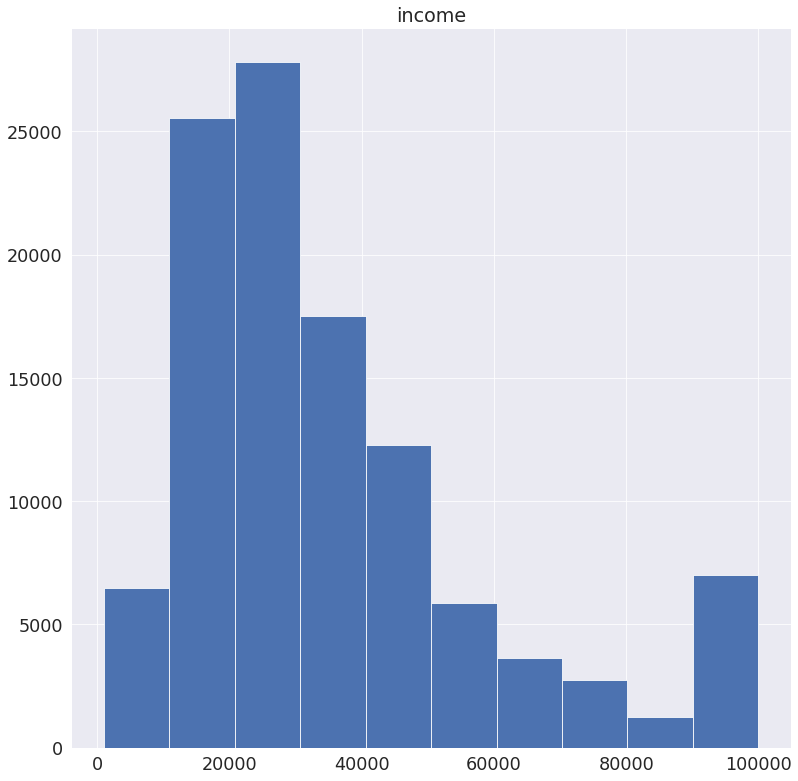

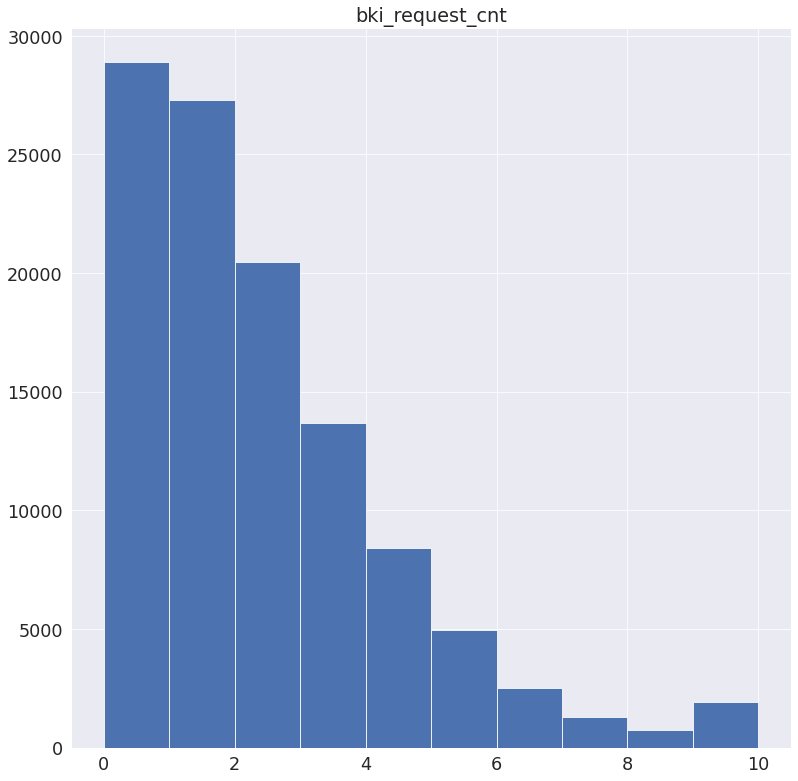

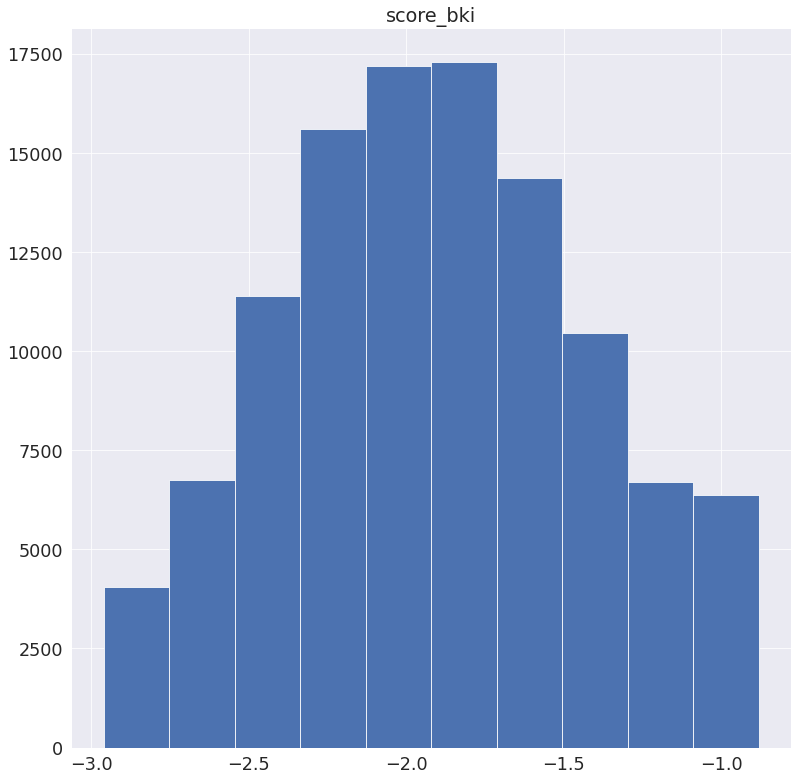

In [155]:
hist_vis(num_cols)

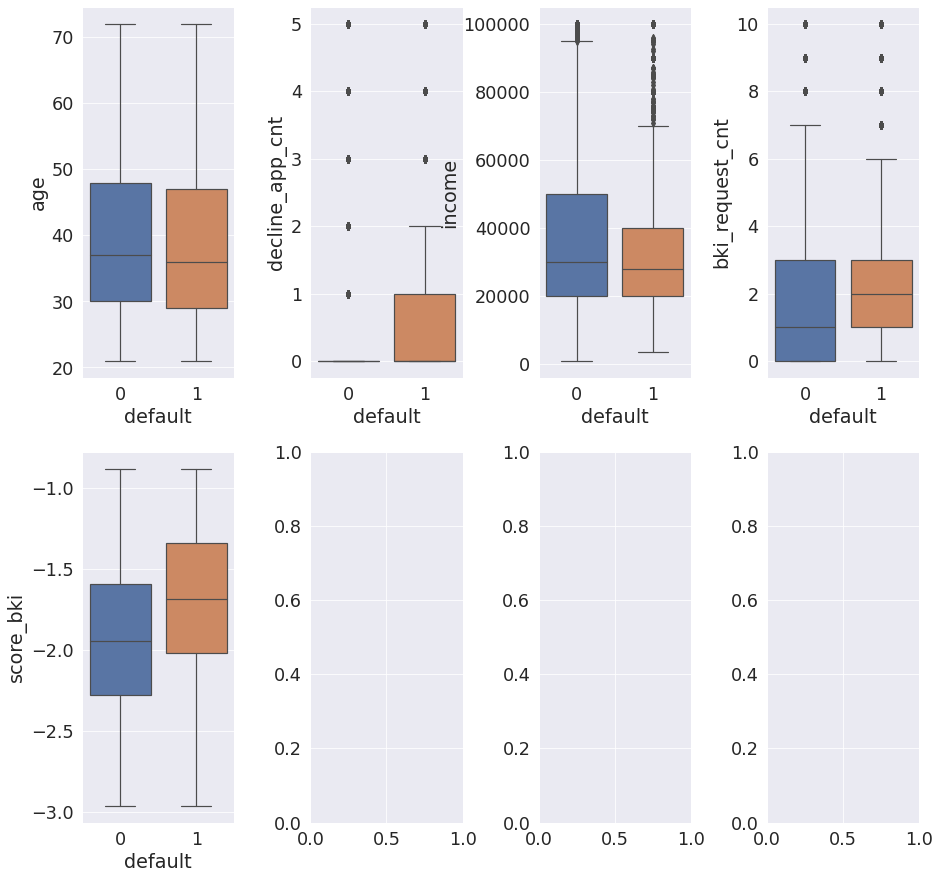

In [156]:
fig, axes = plt.subplots(2, 4, figsize=(15, 15))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()

for i in range(len(num_cols)):
    sns.boxplot(x='default', y=num_cols[i], data=bank_data,
                orient='v', ax=axes[i], showfliers=True)

In [157]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    bank_data[column] = label_encoder.fit_transform(bank_data[column])
    
# убедимся в преобразовании    
bank_data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,1,29,1,1,0,0,-2.271884,3,50,1,2,50000,1,4,0,0,0
1,17527,24JAN2014,SCH,0,39,0,0,5,0,-1.504999,2,50,1,2,5000,4,3,0,0,0
2,75683,23MAR2014,UGR,1,50,1,1,0,0,-1.691339,1,50,1,2,30000,1,3,1,0,0
3,26883,03FEB2014,SCH,1,56,0,0,0,0,-2.374182,1,40,1,2,17000,1,3,0,0,0
4,28862,04FEB2014,GRD,0,38,0,0,0,0,-2.487502,0,80,2,3,100000,1,3,0,0,0


In [158]:
#прологарифмируем числовые
num_cols_log = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']

for i in num_cols_log:
    bank_data[i] = np.log(bank_data[i] + 1)

display(bank_data)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,1,3.401197,1,1,0.000000,0,-2.271884,1.386294,50,1,2,10.819798,1,4,0,0,0
1,17527,24JAN2014,SCH,0,3.688879,0,0,1.791759,0,-1.504999,1.098612,50,1,2,8.517393,4,3,0,0,0
2,75683,23MAR2014,UGR,1,3.931826,1,1,0.000000,0,-1.691339,0.693147,50,1,2,10.308986,1,3,1,0,0
3,26883,03FEB2014,SCH,1,4.043051,0,0,0.000000,0,-2.374182,0.693147,40,1,2,9.741027,1,3,0,0,0
4,28862,04FEB2014,GRD,0,3.663562,0,0,0.000000,0,-2.487502,0.000000,80,2,3,11.512935,1,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,04MAR2014,GRD,0,3.828641,0,0,0.000000,0,-1.792064,1.386294,50,1,2,9.741027,4,4,0,1,0
110144,76821,24MAR2014,SCH,1,3.737670,1,1,0.000000,0,-2.058029,0.693147,50,2,2,11.156265,1,4,0,1,0
110145,103695,22APR2014,SCH,1,3.465736,0,0,0.000000,0,-1.512635,1.609438,80,2,3,10.714440,2,2,0,1,0
110146,861,04JAN2014,SCH,0,3.401197,0,0,0.000000,1,-1.479334,1.386294,50,1,3,9.472782,2,3,0,1,1


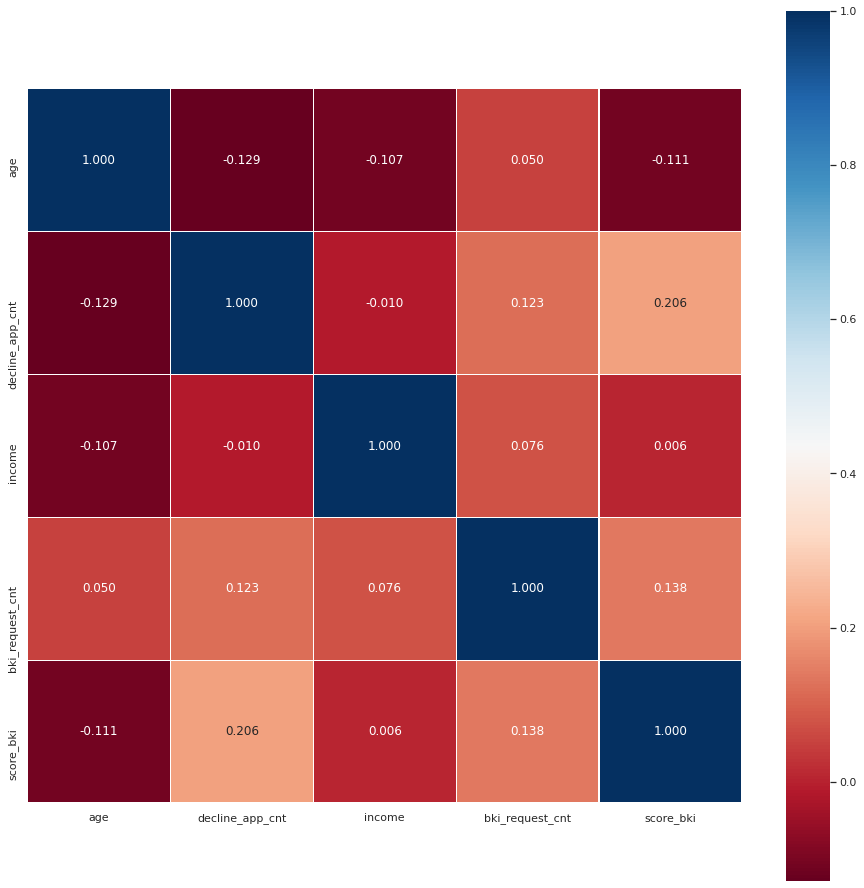

In [159]:
sns.set(font_scale=1)
plt.subplots(figsize=(16, 16))
sns.heatmap(bank_data[num_cols].corr(method='pearson'), square=True,
              annot=True, fmt=".3f", linewidths=0.3, cmap="RdBu")

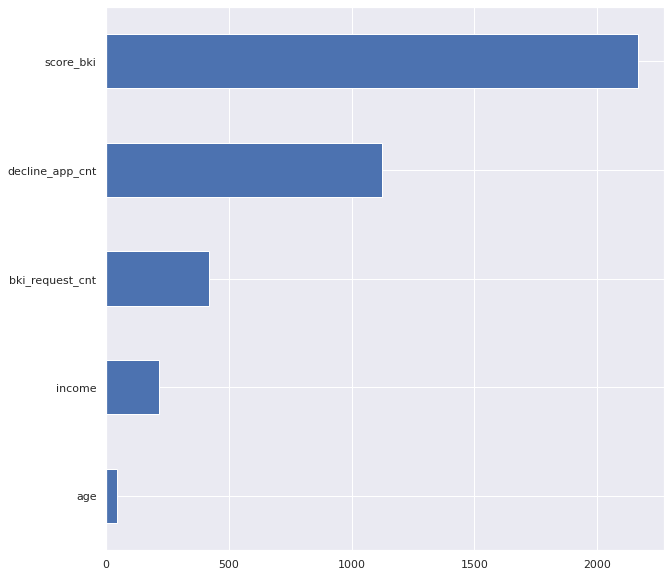

In [160]:
imp_num = Series(f_classif(bank_data[num_cols], bank_data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

0    SCH
dtype: object
count     109670
unique         5
top          SCH
freq       57998
Name: education, dtype: object


,education
SCH,58476
GRD,34768
UGR,14748
PGR,1865
ACD,291


AxesSubplot(0.125,0.125;0.775x0.755)


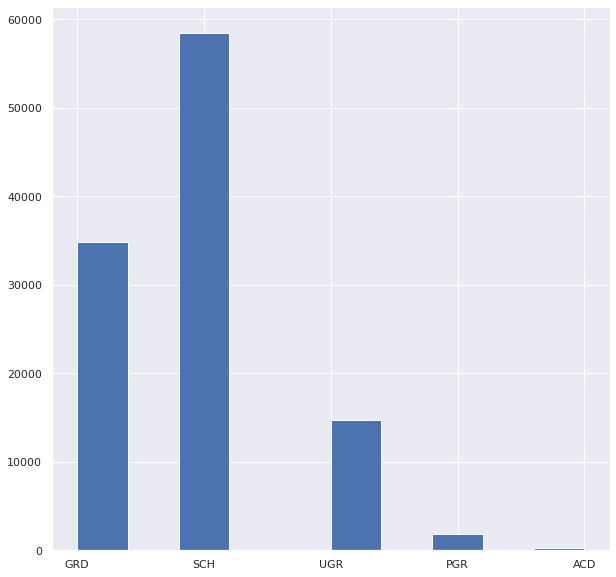

In [161]:
print(bank_data.education.mode())
print(bank_data.education.describe())

bank_data.loc[(bank_data['education'].isnull()), 'education'] = 'SCH'

display(pd.DataFrame(bank_data.education.value_counts()))
# посмотрим на распределение теперь
print(bank_data.education.hist())

In [162]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(bank_data['education']))
print(dict(enumerate(label_encoder.classes_)))
display(bank_data)

{0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,1,3.401197,1,1,0.000000,0,-2.271884,1.386294,50,1,2,10.819798,1,4,0,0,0
1,17527,24JAN2014,SCH,0,3.688879,0,0,1.791759,0,-1.504999,1.098612,50,1,2,8.517393,4,3,0,0,0
2,75683,23MAR2014,UGR,1,3.931826,1,1,0.000000,0,-1.691339,0.693147,50,1,2,10.308986,1,3,1,0,0
3,26883,03FEB2014,SCH,1,4.043051,0,0,0.000000,0,-2.374182,0.693147,40,1,2,9.741027,1,3,0,0,0
4,28862,04FEB2014,GRD,0,3.663562,0,0,0.000000,0,-2.487502,0.000000,80,2,3,11.512935,1,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,04MAR2014,GRD,0,3.828641,0,0,0.000000,0,-1.792064,1.386294,50,1,2,9.741027,4,4,0,1,0
110144,76821,24MAR2014,SCH,1,3.737670,1,1,0.000000,0,-2.058029,0.693147,50,2,2,11.156265,1,4,0,1,0
110145,103695,22APR2014,SCH,1,3.465736,0,0,0.000000,0,-1.512635,1.609438,80,2,3,10.714440,2,2,0,1,0
110146,861,04JAN2014,SCH,0,3.401197,0,0,0.000000,1,-1.479334,1.386294,50,1,3,9.472782,2,3,0,1,1


In [163]:
bank_data['education'] = label_encoder.fit_transform(bank_data['education'])
display(bank_data)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,1,1,3.401197,1,1,0.000000,0,-2.271884,1.386294,50,1,2,10.819798,1,4,0,0,0
1,17527,24JAN2014,3,0,3.688879,0,0,1.791759,0,-1.504999,1.098612,50,1,2,8.517393,4,3,0,0,0
2,75683,23MAR2014,4,1,3.931826,1,1,0.000000,0,-1.691339,0.693147,50,1,2,10.308986,1,3,1,0,0
3,26883,03FEB2014,3,1,4.043051,0,0,0.000000,0,-2.374182,0.693147,40,1,2,9.741027,1,3,0,0,0
4,28862,04FEB2014,1,0,3.663562,0,0,0.000000,0,-2.487502,0.000000,80,2,3,11.512935,1,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,04MAR2014,1,0,3.828641,0,0,0.000000,0,-1.792064,1.386294,50,1,2,9.741027,4,4,0,1,0
110144,76821,24MAR2014,3,1,3.737670,1,1,0.000000,0,-2.058029,0.693147,50,2,2,11.156265,1,4,0,1,0
110145,103695,22APR2014,3,1,3.465736,0,0,0.000000,0,-1.512635,1.609438,80,2,3,10.714440,2,2,0,1,0
110146,861,04JAN2014,3,0,3.401197,0,0,0.000000,1,-1.479334,1.386294,50,1,3,9.472782,2,3,0,1,1


In [164]:
bank_data['region_rating'] = label_encoder.fit_transform(
    bank_data['region_rating'])
display(bank_data)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,1,1,3.401197,1,1,0.000000,0,-2.271884,1.386294,3,1,2,10.819798,1,4,0,0,0
1,17527,24JAN2014,3,0,3.688879,0,0,1.791759,0,-1.504999,1.098612,3,1,2,8.517393,4,3,0,0,0
2,75683,23MAR2014,4,1,3.931826,1,1,0.000000,0,-1.691339,0.693147,3,1,2,10.308986,1,3,1,0,0
3,26883,03FEB2014,3,1,4.043051,0,0,0.000000,0,-2.374182,0.693147,2,1,2,9.741027,1,3,0,0,0
4,28862,04FEB2014,1,0,3.663562,0,0,0.000000,0,-2.487502,0.000000,6,2,3,11.512935,1,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,04MAR2014,1,0,3.828641,0,0,0.000000,0,-1.792064,1.386294,3,1,2,9.741027,4,4,0,1,0
110144,76821,24MAR2014,3,1,3.737670,1,1,0.000000,0,-2.058029,0.693147,3,2,2,11.156265,1,4,0,1,0
110145,103695,22APR2014,3,1,3.465736,0,0,0.000000,0,-1.512635,1.609438,6,2,3,10.714440,2,2,0,1,0
110146,861,04JAN2014,3,0,3.401197,0,0,0.000000,1,-1.479334,1.386294,3,1,3,9.472782,2,3,0,1,1


In [ ]:
# print(type(bank_data.app_date[0]))
# bank_data['app_date']=pd.to_datetime(bank_data['app_date'])
# #перевод строки в дату
# #bank_data['app_date'] = datetime.strptime(bank_data['app_date'], '%d.%b.%Y')

# #bank_data['app_date'] = bank_data['app_date'].apply(lambda _: datetime.strptime(_,"%d%b%Y"))


# print(type(bank_data.app_date[0]))
# print(bank_data.head(2))
# print(bank_data.app_date[0])
# print(bank_data.app_date[0].month)


<class 'str'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
   client_id   app_date  education  ...  foreign_passport  sample  default
0      74835 2014-03-22          1  ...                 0       0        0
1      17527 2014-01-24          3  ...                 0       0        0

[2 rows x 20 columns]
2014-03-22 00:00:00
3


In [ ]:
# bank_data['day'] = np.nan
# print(bank_data.app_date[0].weekday())
# #bank_data['day'] = bank_data.app_date.weekday()
# #bank_data['day'] = bank_data['app_date'].apply(lambda _: bank_data.app_date.weekday())
# def fill_day(data_day):
#   return data_day.weekday()


# bank_data['day'] = bank_data['app_date'].apply(fill_day)
# print(bank_data.head(2))

In [ ]:
#data['release_date'].dt.month
# bank_data['season'] = np.nan
# def fill_season(data_season):
#   if (data_season.month==6)|(data_season.month==7)|(data_season.month==8):
#     return 2
#   elif (data_season.month==9)|(data_season.month==10)|(data_season.month==11):
#     return 3
#   elif (data_season.month==12)|(data_season.month==1)|(data_season.month==2):
#     return 4
#   else:
#     return 1

# bank_data['season'] = bank_data['app_date'].apply(fill_season)
# display(bank_data.head(2))

#bank_data['season'] = data[(data['release_date'].dt.month==6)|(data['release_date'].dt.month==7)|(data['release_date'].dt.month==8)]

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,season
0,74835,2014-03-22,1,1,3.401197,1,1,0.000000,0,-2.271884,1.386294,3,1,2,10.819798,1,4,0,0,0,1
1,17527,2014-01-24,3,0,3.688879,0,0,1.791759,0,-1.504999,1.098612,3,1,2,8.517393,4,3,0,0,0,4


игры с датой не приносят особых изменений

In [165]:
#bank_data['day'] = bank_data['app_date'].apply(lambda _: bank_data.app_date.weekday())
#добавим новый признак "успешности"
bank_data['success_rate'] = bank_data.good_work+bank_data.car_type+bank_data.foreign_passport

display(bank_data.head(2))


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,success_rate
0,74835,22MAR2014,1,1,3.401197,1,1,0.000000,0,-2.271884,1.386294,3,1,2,10.819798,1,4,0,0,0,1
1,17527,24JAN2014,3,0,3.688879,0,0,1.791759,0,-1.504999,1.098612,3,1,2,8.517393,4,3,0,0,0,0


,success_rate
0,65826
1,34171
2,8958
3,1193


AxesSubplot(0.125,0.125;0.775x0.755)


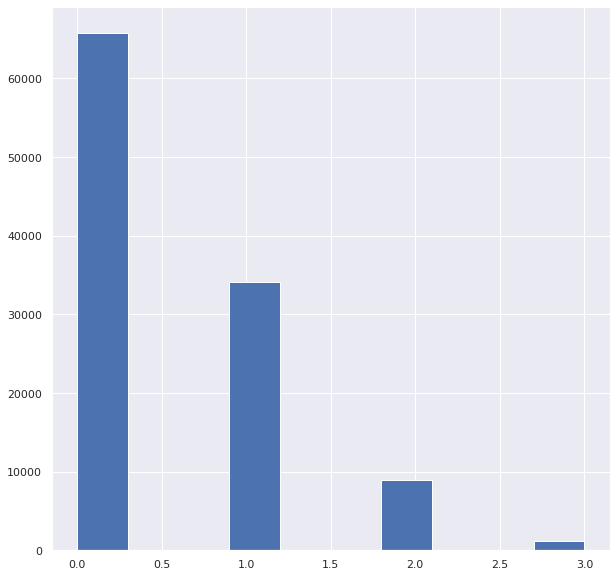

In [166]:
display(pd.DataFrame(bank_data.success_rate.value_counts()))
# посмотрим на распределение
print(bank_data.success_rate.hist())

In [167]:
#обновим данные
cat_cols = ['education', 'work_address', 'home_address', 'sna', 'first_time', 'region_rating', 'success_rate']

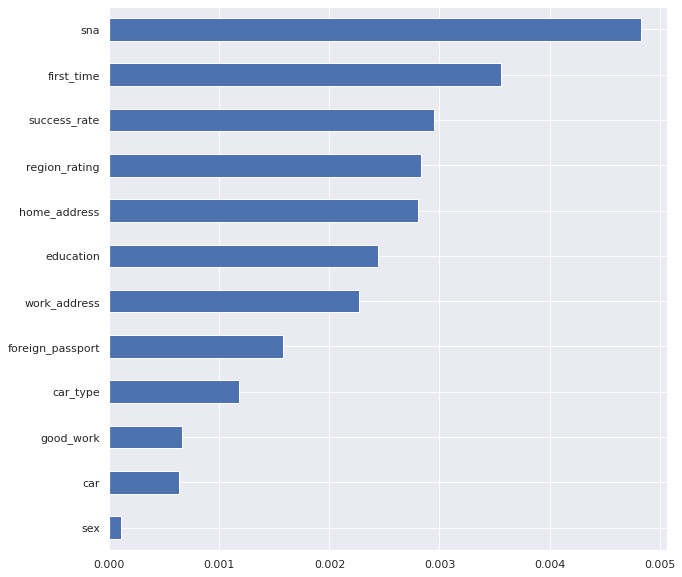

In [168]:
imp_cat = Series(mutual_info_classif(bank_data[bin_cols + cat_cols], bank_data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

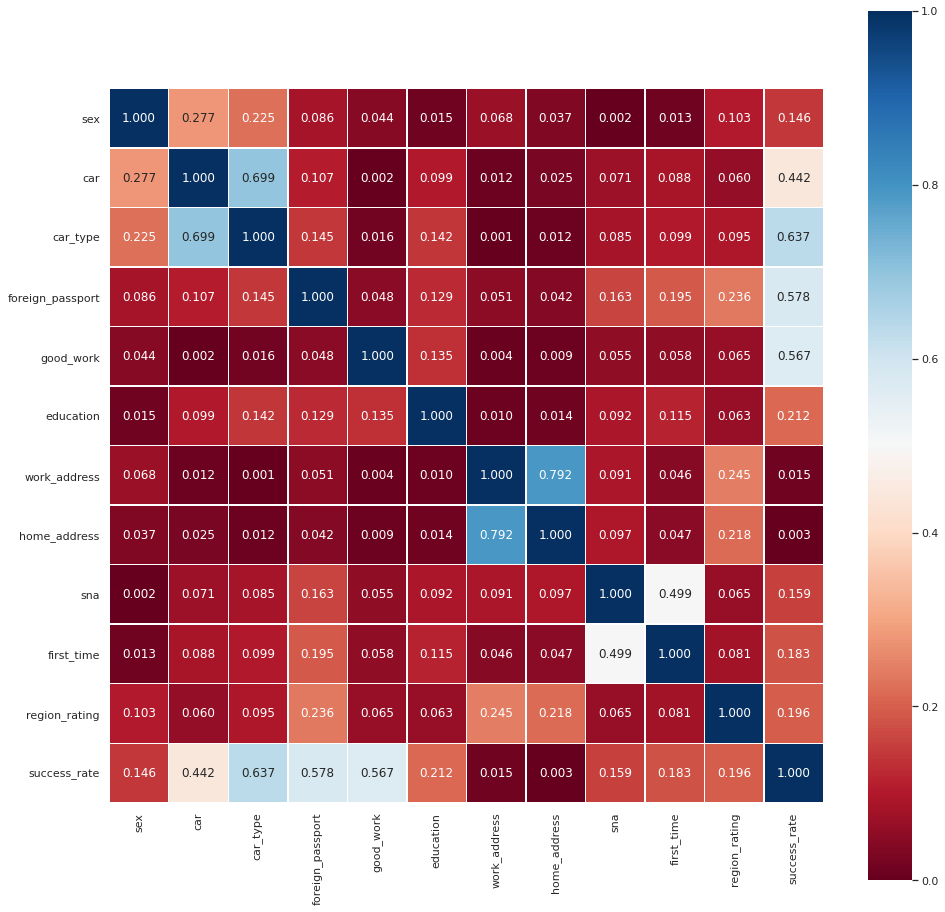

In [169]:
# оценим корреляцию Спирмана для нечисловых переменных
sns.set(font_scale=1)
plt.subplots(figsize=(16, 16))
sns.heatmap(bank_data[bin_cols + cat_cols].corr(method='spearman').abs(), square=True,
              annot=True, fmt=".3f", linewidths=0.3, cmap="RdBu", vmin=0, vmax=1)
#sns.heatmap(bank_data[bin_cols + cat_cols].corr(method='spearman').abs(), vmin=0, vmax=1)


#Выводы: 1.Высокая корреляция перемнных car и car_type. В модели будем использовать перемнную car. 2.Высокая корреляция переменных home_address и work_address. В модели будем использовать перемнную work_address.


In [170]:
#bank_data = bank_data.drop(['client_id','app_date','home_address','car'], axis=1)
bank_data = bank_data.drop(['home_address','car_type', 'foreign_passport', 'good_work'], axis=1)
# разделим снова на train_df и test_df
# train_data = bank_data[bank_data['sample']== 1].drop(['sample'], axis=1)
# test_data = bank_data[bank_data['sample']== 0].drop(['sample'], axis=1)
display(bank_data)

,client_id,app_date,education,sex,age,car,decline_app_cnt,score_bki,bki_request_cnt,region_rating,work_address,income,sna,first_time,sample,default,success_rate
0,74835,22MAR2014,1,1,3.401197,1,0.000000,-2.271884,1.386294,3,2,10.819798,1,4,0,0,1
1,17527,24JAN2014,3,0,3.688879,0,1.791759,-1.504999,1.098612,3,2,8.517393,4,3,0,0,0
2,75683,23MAR2014,4,1,3.931826,1,0.000000,-1.691339,0.693147,3,2,10.308986,1,3,0,0,2
3,26883,03FEB2014,3,1,4.043051,0,0.000000,-2.374182,0.693147,2,2,9.741027,1,3,0,0,0
4,28862,04FEB2014,1,0,3.663562,0,0.000000,-2.487502,0.000000,6,3,11.512935,1,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,04MAR2014,1,0,3.828641,0,0.000000,-1.792064,1.386294,3,2,9.741027,4,4,1,0,0
110144,76821,24MAR2014,3,1,3.737670,1,0.000000,-2.058029,0.693147,3,2,11.156265,1,4,1,0,1
110145,103695,22APR2014,3,1,3.465736,0,0.000000,-1.512635,1.609438,6,3,10.714440,2,2,1,0,0
110146,861,04JAN2014,3,0,3.401197,0,0.000000,-1.479334,1.386294,3,3,9.472782,2,3,1,1,1


In [171]:
#все полиномы 2й степени от численных переменных
num_features = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']
#results_polinome2all=pd.DataFrame(data=None, columns=None)

pf = PolynomialFeatures(2)
poly_features = pf.fit_transform(bank_data[num_features])
new_features=["A"+str(k) for k in range(0,np.shape(poly_features)[1])]
print(new_features)

df_temp=pd.DataFrame(poly_features,columns=new_features)
df_temp.index = bank_data.index
display(df_temp)
new_features = new_features[len(num_features)+1:]
print(new_features)
display(df_temp[new_features])
display(bank_data.head(10))
bank_data = pd.concat([bank_data, df_temp[new_features]], axis=1)
display(bank_data)
num_cols_1=num_features+new_features
print(num_cols_1)

['A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20']


,A0,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20
0,1.0,3.401197,0.000000,-2.271884,1.386294,10.819798,11.568144,0.000000,-7.727125,4.715061,36.800270,0.000000,-0.000000,0.000000,0.00000,5.161455,-3.149500,-24.581323,1.921812,14.999425,117.068035
1,1.0,3.688879,1.791759,-1.504999,1.098612,8.517393,13.607832,6.609585,-5.551760,4.052648,31.419637,3.210402,-2.696596,1.968449,15.26112,2.265022,-1.653411,-12.818669,1.206949,9.357313,72.545986
2,1.0,3.931826,0.000000,-1.691339,0.693147,10.308986,15.459253,0.000000,-6.650050,2.725334,40.533135,0.000000,-0.000000,0.000000,0.00000,2.860628,-1.172347,-17.435990,0.480453,7.145645,106.275192
3,1.0,4.043051,0.000000,-2.374182,0.693147,9.741027,16.346264,0.000000,-9.598941,2.802430,39.383473,0.000000,-0.000000,0.000000,0.00000,5.636742,-1.645658,-23.126977,0.480453,6.751966,94.887616
4,1.0,3.663562,0.000000,-2.487502,0.000000,11.512935,13.421684,0.000000,-9.113118,0.000000,42.178349,0.000000,-0.000000,0.000000,0.00000,6.187668,-0.000000,-28.638455,0.000000,0.000000,132.547683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,1.0,3.828641,0.000000,-1.792064,1.386294,9.741027,14.658495,0.000000,-6.861172,5.307624,37.294901,0.000000,-0.000000,0.000000,0.00000,3.211495,-2.484329,-17.456548,1.921812,13.503931,94.887616
110144,1.0,3.737670,0.000000,-2.058029,0.693147,11.156265,13.970174,0.000000,-7.692233,2.590755,41.698432,0.000000,-0.000000,0.000000,0.00000,4.235484,-1.426517,-22.959919,0.480453,7.732933,124.462244
110145,1.0,3.465736,0.000000,-1.512635,1.609438,10.714440,12.011325,0.000000,-5.242392,5.577887,37.133419,0.000000,-0.000000,0.000000,0.00000,2.288064,-2.434492,-16.207034,2.590290,17.244226,114.799224
110146,1.0,3.401197,0.000000,-1.479334,1.386294,9.472782,11.568144,0.000000,-5.031506,4.715061,32.218800,0.000000,-0.000000,0.000000,0.00000,2.188428,-2.050792,-14.013406,1.921812,13.132064,89.733590


['A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20']


,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20
0,11.568144,0.000000,-7.727125,4.715061,36.800270,0.000000,-0.000000,0.000000,0.00000,5.161455,-3.149500,-24.581323,1.921812,14.999425,117.068035
1,13.607832,6.609585,-5.551760,4.052648,31.419637,3.210402,-2.696596,1.968449,15.26112,2.265022,-1.653411,-12.818669,1.206949,9.357313,72.545986
2,15.459253,0.000000,-6.650050,2.725334,40.533135,0.000000,-0.000000,0.000000,0.00000,2.860628,-1.172347,-17.435990,0.480453,7.145645,106.275192
3,16.346264,0.000000,-9.598941,2.802430,39.383473,0.000000,-0.000000,0.000000,0.00000,5.636742,-1.645658,-23.126977,0.480453,6.751966,94.887616
4,13.421684,0.000000,-9.113118,0.000000,42.178349,0.000000,-0.000000,0.000000,0.00000,6.187668,-0.000000,-28.638455,0.000000,0.000000,132.547683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,14.658495,0.000000,-6.861172,5.307624,37.294901,0.000000,-0.000000,0.000000,0.00000,3.211495,-2.484329,-17.456548,1.921812,13.503931,94.887616
110144,13.970174,0.000000,-7.692233,2.590755,41.698432,0.000000,-0.000000,0.000000,0.00000,4.235484,-1.426517,-22.959919,0.480453,7.732933,124.462244
110145,12.011325,0.000000,-5.242392,5.577887,37.133419,0.000000,-0.000000,0.000000,0.00000,2.288064,-2.434492,-16.207034,2.590290,17.244226,114.799224
110146,11.568144,0.000000,-5.031506,4.715061,32.218800,0.000000,-0.000000,0.000000,0.00000,2.188428,-2.050792,-14.013406,1.921812,13.132064,89.733590


,client_id,app_date,education,sex,age,car,decline_app_cnt,score_bki,bki_request_cnt,region_rating,work_address,income,sna,first_time,sample,default,success_rate
0,74835,22MAR2014,1,1,3.401197,1,0.000000,-2.271884,1.386294,3,2,10.819798,1,4,0,0,1
1,17527,24JAN2014,3,0,3.688879,0,1.791759,-1.504999,1.098612,3,2,8.517393,4,3,0,0,0
2,75683,23MAR2014,4,1,3.931826,1,0.000000,-1.691339,0.693147,3,2,10.308986,1,3,0,0,2
3,26883,03FEB2014,3,1,4.043051,0,0.000000,-2.374182,0.693147,2,2,9.741027,1,3,0,0,0
4,28862,04FEB2014,1,0,3.663562,0,0.000000,-2.487502,0.000000,6,3,11.512935,1,3,0,0,0
5,99881,17APR2014,3,0,4.025352,0,0.000000,-1.740224,2.079442,3,3,10.308986,2,1,0,0,0
6,26630,02FEB2014,3,0,3.433987,0,1.386294,-1.387847,1.791759,4,2,9.305741,4,3,0,0,0
7,79934,28MAR2014,1,1,3.737670,1,0.000000,-2.960000,1.386294,4,3,11.289794,4,1,0,0,1
8,16605,23JAN2014,1,1,3.555348,0,0.000000,-2.960000,0.000000,6,3,8.517393,1,2,0,0,0
9,105449,24APR2014,4,1,3.367296,1,0.000000,-2.185172,0.000000,6,3,11.289794,1,3,0,0,2


,client_id,app_date,education,sex,age,car,decline_app_cnt,score_bki,bki_request_cnt,region_rating,work_address,income,sna,first_time,sample,default,success_rate,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20
0,74835,22MAR2014,1,1,3.401197,1,0.000000,-2.271884,1.386294,3,2,10.819798,1,4,0,0,1,11.568144,0.000000,-7.727125,4.715061,36.800270,0.000000,-0.000000,0.000000,0.00000,5.161455,-3.149500,-24.581323,1.921812,14.999425,117.068035
1,17527,24JAN2014,3,0,3.688879,0,1.791759,-1.504999,1.098612,3,2,8.517393,4,3,0,0,0,13.607832,6.609585,-5.551760,4.052648,31.419637,3.210402,-2.696596,1.968449,15.26112,2.265022,-1.653411,-12.818669,1.206949,9.357313,72.545986
2,75683,23MAR2014,4,1,3.931826,1,0.000000,-1.691339,0.693147,3,2,10.308986,1,3,0,0,2,15.459253,0.000000,-6.650050,2.725334,40.533135,0.000000,-0.000000,0.000000,0.00000,2.860628,-1.172347,-17.435990,0.480453,7.145645,106.275192
3,26883,03FEB2014,3,1,4.043051,0,0.000000,-2.374182,0.693147,2,2,9.741027,1,3,0,0,0,16.346264,0.000000,-9.598941,2.802430,39.383473,0.000000,-0.000000,0.000000,0.00000,5.636742,-1.645658,-23.126977,0.480453,6.751966,94.887616
4,28862,04FEB2014,1,0,3.663562,0,0.000000,-2.487502,0.000000,6,3,11.512935,1,3,0,0,0,13.421684,0.000000,-9.113118,0.000000,42.178349,0.000000,-0.000000,0.000000,0.00000,6.187668,-0.000000,-28.638455,0.000000,0.000000,132.547683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,04MAR2014,1,0,3.828641,0,0.000000,-1.792064,1.386294,3,2,9.741027,4,4,1,0,0,14.658495,0.000000,-6.861172,5.307624,37.294901,0.000000,-0.000000,0.000000,0.00000,3.211495,-2.484329,-17.456548,1.921812,13.503931,94.887616
110144,76821,24MAR2014,3,1,3.737670,1,0.000000,-2.058029,0.693147,3,2,11.156265,1,4,1,0,1,13.970174,0.000000,-7.692233,2.590755,41.698432,0.000000,-0.000000,0.000000,0.00000,4.235484,-1.426517,-22.959919,0.480453,7.732933,124.462244
110145,103695,22APR2014,3,1,3.465736,0,0.000000,-1.512635,1.609438,6,3,10.714440,2,2,1,0,0,12.011325,0.000000,-5.242392,5.577887,37.133419,0.000000,-0.000000,0.000000,0.00000,2.288064,-2.434492,-16.207034,2.590290,17.244226,114.799224
110146,861,04JAN2014,3,0,3.401197,0,0.000000,-1.479334,1.386294,3,3,9.472782,2,3,1,1,1,11.568144,0.000000,-5.031506,4.715061,32.218800,0.000000,-0.000000,0.000000,0.00000,2.188428,-2.050792,-14.013406,1.921812,13.132064,89.733590


['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20']


In [ ]:
# bin_cols_1 = ['sex', 'car']
# # столбцы с категориальными характеристиками 5
# cat_cols_1 = ['education', 'work_address', 'sna', 'first_time', 'region_rating', 'success_rate']

# X_cat = OneHotEncoder(sparse = False).fit_transform(train_data[cat_cols_1].values)
# print(X_cat.shape)

(73799, 27)


In [172]:
# Стандартизация числовых переменных
ss = StandardScaler()
bank_data[num_cols_1] = pd.DataFrame(ss.fit_transform(bank_data[num_cols_1]),columns = bank_data[num_cols_1].columns)

In [173]:
display(bank_data)

,client_id,app_date,education,sex,age,car,decline_app_cnt,score_bki,bki_request_cnt,region_rating,work_address,income,sna,first_time,sample,default,success_rate,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20
0,74835,22MAR2014,1,1,-0.888776,1,-0.422303,-0.750507,0.784493,3,2,0.777333,1,4,0,0,1,-0.894530,-0.422664,-0.385508,0.622947,-0.254138,-0.343299,0.412369,-0.334672,-0.421474,0.695271,-1.195910,-0.945278,0.578969,0.868145,0.768214
1,17527,24JAN2014,3,0,0.120447,0,4.611371,0.832101,0.342401,3,2,-2.820658,4,3,0,0,0,0.081790,4.786391,0.750574,0.348783,-1.767071,7.038662,-4.013069,3.781872,3.730045,-0.871430,-0.020229,1.330494,0.013040,0.041811,-2.615762
2,75683,23MAR2014,4,1,0.972731,1,-0.422303,0.447554,-0.280693,3,2,-0.020919,1,3,0,0,2,0.967995,-0.422664,0.176993,-0.200576,0.795474,-0.343299,0.412369,-0.334672,-0.421474,-0.549262,0.357808,0.437161,-0.562099,-0.282106,-0.052115
3,26883,03FEB2014,3,1,1.362924,0,-0.422303,-0.961620,-0.280693,2,2,-0.908473,1,3,0,0,0,1.392573,-0.422664,-1.363062,-0.168667,0.472211,-0.343299,0.412369,-0.334672,-0.421474,0.952357,-0.014137,-0.663899,-0.562099,-0.339764,-0.917648
4,28862,04FEB2014,1,0,0.031629,0,-0.422303,-1.195477,-1.345879,6,3,1.860505,1,3,0,0,0,-0.007312,-0.422664,-1.109342,-1.328559,1.258077,-0.343299,0.412369,-0.334672,-0.421474,1.250357,1.279081,-1.730229,-0.942455,-1.328645,1.944771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,04MAR2014,1,0,0.610749,0,-0.422303,0.239689,0.784493,3,2,-0.908473,4,4,1,0,0,0.584702,-0.422664,0.066735,0.868202,-0.115057,-0.343299,0.412369,-0.334672,-0.421474,-0.359476,-0.673195,0.433183,0.578969,0.649118,-0.917648
110144,76821,24MAR2014,3,1,0.291609,1,-0.422303,-0.309179,-0.280693,3,2,1.303132,1,4,1,0,1,0.255230,-0.422664,-0.367286,-0.256277,1.123134,-0.343299,0.412369,-0.334672,-0.421474,0.194407,0.158072,-0.631578,-0.562099,-0.196093,1.330224
110145,103695,22APR2014,3,1,-0.662367,0,-0.422303,0.816344,1.127406,6,3,0.612688,2,2,1,0,0,-0.682396,-0.422664,0.912141,0.980060,-0.160463,-0.343299,0.412369,-0.334672,-0.421474,-0.858966,-0.634031,0.674932,1.108177,1.196915,0.595769
110146,861,04JAN2014,3,0,-0.888776,0,-0.422303,0.885066,0.784493,3,3,-1.327663,2,3,1,1,1,-0.894530,-0.422664,1.022276,0.622947,-1.542362,-0.343299,0.412369,-0.334672,-0.421474,-0.912860,-0.332506,1.099343,0.578969,0.594654,-1.309388


In [174]:
# Encoding categorical variables.
# столбцы с категориальными характеристиками
cat_cols_1 = ['education', 'work_address', 'sna', 'first_time', 'region_rating', 'success_rate']
bank_data = pd.get_dummies(bank_data, prefix=cat_cols_1, columns=cat_cols_1)
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 53 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   client_id        110148 non-null  int64  
 1   app_date         110148 non-null  object 
 2   sex              110148 non-null  int64  
 3   age              110148 non-null  float64
 4   car              110148 non-null  int64  
 5   decline_app_cnt  110148 non-null  float64
 6   score_bki        110148 non-null  float64
 7   bki_request_cnt  110148 non-null  float64
 8   income           110148 non-null  float64
 9   sample           110148 non-null  int64  
 10  default          110148 non-null  int64  
 11  A6               110148 non-null  float64
 12  A7               110148 non-null  float64
 13  A8               110148 non-null  float64
 14  A9               110148 non-null  float64
 15  A10              110148 non-null  float64
 16  A11              110148 non-null  floa

In [175]:
# разделим снова на train_df и test_df
train_data = bank_data.query('sample == 1').drop(['sample', 'client_id', 'app_date'], axis=1)
test_data = bank_data.query('sample == 0').drop(['sample', 'client_id', 'app_date'], axis=1)

In [176]:
# сформируем
X = train_data.drop(['default'], axis=1)
Y = train_data['default'].values

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=RANDOM_SEED)

In [178]:
model_1 = LogisticRegression()
model_1.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [180]:
Y_predicted = model_1.predict(X_test)

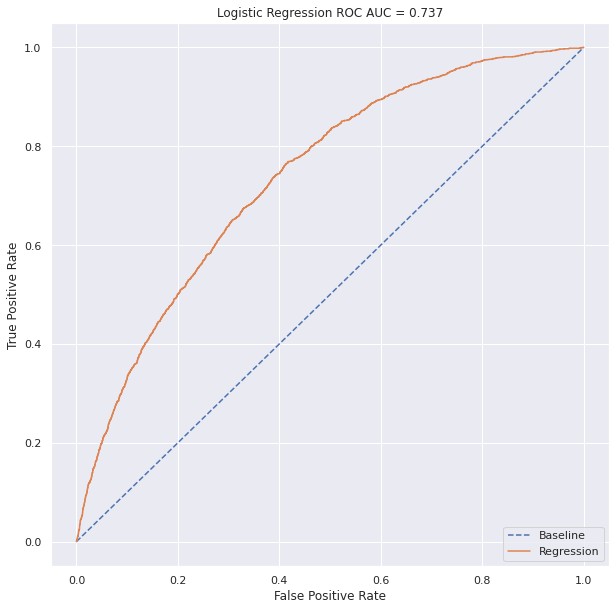

[[12886    47]
 [ 1800    27]]


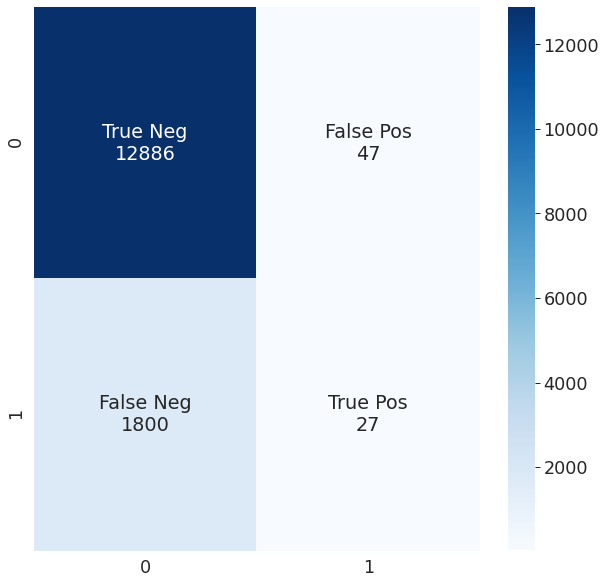

In [181]:
probs = model_1.predict_proba(X_test)
y_pred_probs = probs[:,1]

#y_pred = model0.predict(X_test)
roc_auc_curve(y_test, y_pred_probs)


# confusion matrix
cm = confusion_matrix(y_test, Y_predicted)
print(cm)

# визуализация confusion matrix
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

# probs = model.predict_proba(X_test)
# probs = probs[:, 1]


# fpr, tpr, threshold = roc_curve(y_test, probs)
# roc_auc = roc_auc_score(y_test, probs)

# # Визуализация ROC AUC
# plt.figure()
# plt.plot([0, 1], label='Baseline', linestyle='--')
# plt.plot(fpr, tpr, label='Regression')
# plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.legend(loc='lower right')
# plt.show()



In [182]:
# сравним метрики с предыдущей моделью
summary_metrics(summary,'model_1',y_test,Y_predicted,y_pred_probs)

,model_0,new_model_0,model_us_0,model_1
accuracy,0.875542,0.665718,0.678581,0.874864
precision,0.445652,0.223626,0.671362,0.364865
recall,0.022441,0.688013,0.691192,0.014778
f1_score,0.042731,0.337540,0.681133,0.028406
ROC_AUC,0.741925,0.741504,0.737270,0.737161


Алгоритм кредитного скоринга должен определять надежность заемщиков. Банку хочется давать кредиты только тем, кто их вернет
При оценке работы такого алгоритма внимание стоит обращать на метрику точности(precision). Она покажет, в ком ошибся алгоритм. Именно таких людей, недобросовестных заемщиков, которые обманули модель, банк не хочет видеть среди клиентов. Значит, их число и надо снижать, повышая точность.

In [ ]:
#Код, который выполнять не нужно
%%script false
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])
best_parameters = best_model.get_params()
print(f'Лучшие значения параметров:') 
for param_name in best_parameters.keys():
        print(f'  {param_name} = {best_parameters[param_name]},')

In [183]:
#подберем гиперпараметры
#model = LogisticRegression(random_state=42)
param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}, 
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}, 
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}
     ]
gridsearch = GridSearchCV(model_1, param_grid, scoring='f1', n_jobs=-1)
gridsearch.fit(X_train, y_train)
model_1 = gridsearch.best_estimator_
## печатаем параметры
best_parameters = model_1.get_params()
# View best hyperparameters
print(f'Лучшие значения параметров:') 
for param_name in best_parameters.keys():
        print(f'  {param_name} = {best_parameters[param_name]},')

Лучшие значения параметров:
  C = 1.0,
  class_weight = balanced,
  dual = False,
  fit_intercept = True,
  intercept_scaling = 1,
  l1_ratio = None,
  max_iter = 100,
  multi_class = auto,
  n_jobs = None,
  penalty = none,
  random_state = None,
  solver = newton-cg,
  tol = 0.0001,
  verbose = 0,
  warm_start = False,


In [184]:
# Разобьем данные для обучения и тестирования по новой
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [185]:
# строим модель
new_model_1 = LogisticRegression(random_state = None, 
                               C = 1, 
                               class_weight = 'balanced', 
                               dual = False, 
                               fit_intercept = True, 
                               intercept_scaling = 1, 
                               l1_ratio = None, 
                               max_iter = 100, 
                               multi_class = 'auto', 
                               n_jobs = None, 
                               penalty = 'none', 
                               solver = 'newton-cg', 
                               tol = 0.0001,
                               verbose = 0, 
                               warm_start = False)
new_model_1.fit(X_train, y_train)

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [186]:
#обучили
Y_predicted = new_model_1.predict(X_test)

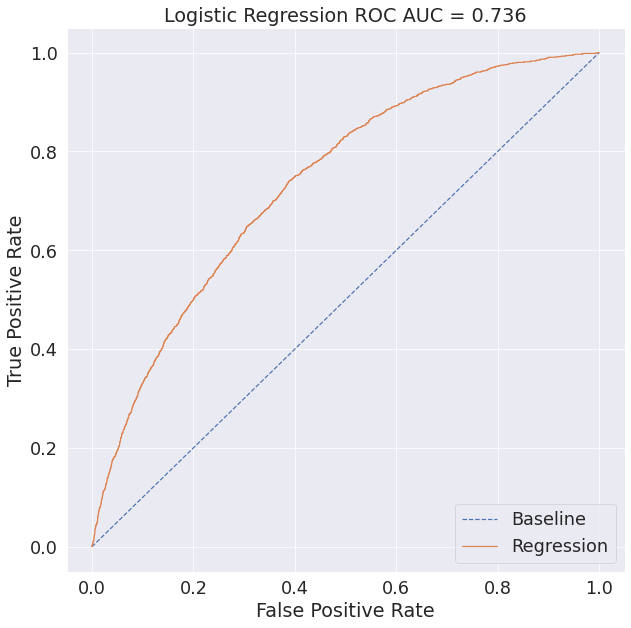

Positive: 1827, Negative: 12933
[[8556 4377]
 [ 588 1239]]


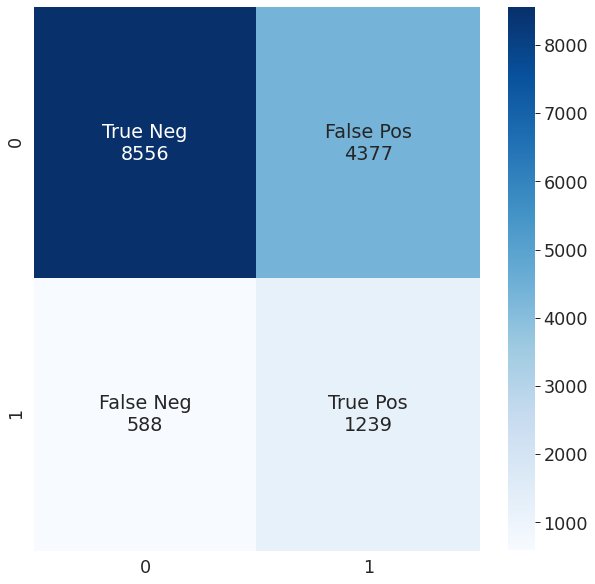

In [187]:
probs = new_model_1.predict_proba(X_test)
y_pred_probs = probs[:,1]

#y_pred = new_model_0.predict(X_test)
roc_auc_curve(y_test, y_pred_probs)


# confusion matrix
P = np.sum(y_test == 1)
N = np.sum(y_test == 0)
print('Positive: {0}, Negative: {1}'.format(P, N))

cm = confusion_matrix(y_test, Y_predicted)
print(cm)

# визуализация confusion matrix
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

In [188]:
# сравним метрики с предыдущей моделью
summary_metrics(summary,'new_model_1',y_test,Y_predicted,y_pred_probs)

,model_0,new_model_0,model_us_0,model_1,new_model_1
accuracy,0.875542,0.665718,0.678581,0.874864,0.663618
precision,0.445652,0.223626,0.671362,0.364865,0.220620
recall,0.022441,0.688013,0.691192,0.014778,0.678161
f1_score,0.042731,0.337540,0.681133,0.028406,0.332930
ROC_AUC,0.741925,0.741504,0.737270,0.737161,0.736489


[train] F1-score = 0.74 +/- 0.00
[valid] F1-score = 0.73 +/- 0.02


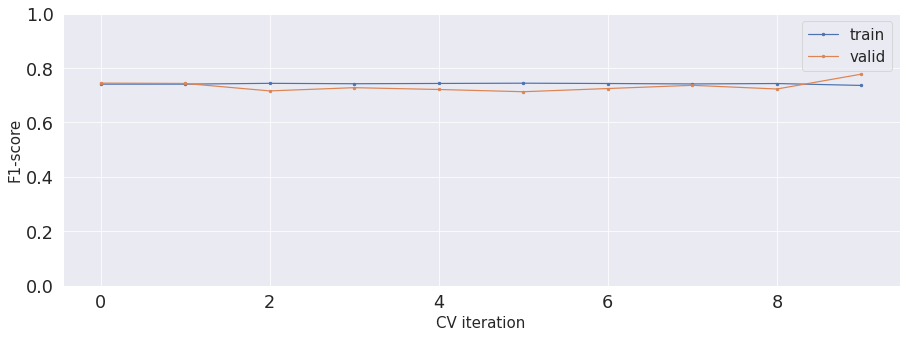

In [189]:
temp_vec = cross_validate(new_model_1, X_test, y_test, cv=10, scoring='roc_auc', return_train_score=True)
plot_cv_metrics(temp_vec)

In [193]:
from imblearn.under_sampling import RandomUnderSampler


rus = RandomUnderSampler(random_state=42)
X_us, y_us = rus.fit_resample(X, Y)

X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(X_us, y_us, test_size=0.20, shuffle = True, random_state=RANDOM_SEED)
#model_us = LogisticRegression()
#model_us.fit(X_train_us, y_train_us)
model_us_1 = LogisticRegression(random_state = None, 
                               C = 1, 
                               class_weight = 'balanced', 
                               dual = False, 
                               fit_intercept = True, 
                               intercept_scaling = 1, 
                               l1_ratio = None, 
                               max_iter = 100, 
                               multi_class = 'auto', 
                               n_jobs = None, 
                               penalty = 'none', 
                               solver = 'newton-cg', 
                               tol = 0.0001,
                               verbose = 0, 
                               warm_start = False)


model_us_1.fit(X_train_us, y_train_us)

probs = model_us_1.predict_proba(X_test_us)
y_pred_probs = probs[:,1]

Y_predicted = model_us_1.predict(X_test_us)

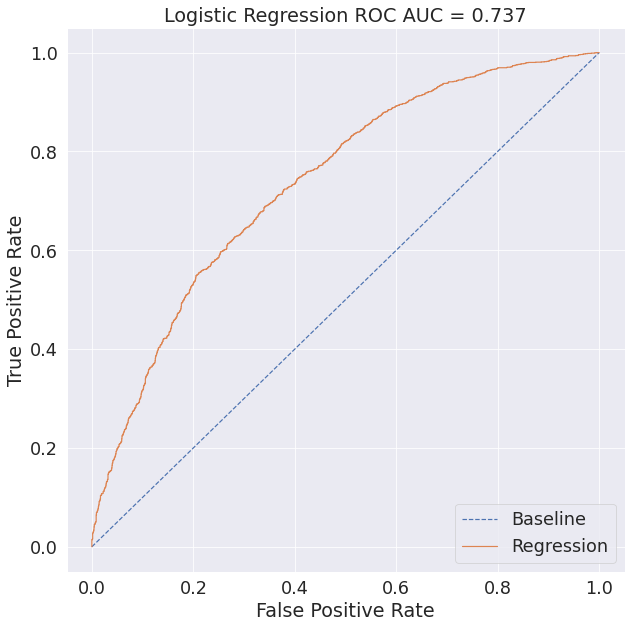

Positive: 1862, Negative: 1887
[[1247  640]
 [ 593 1269]]


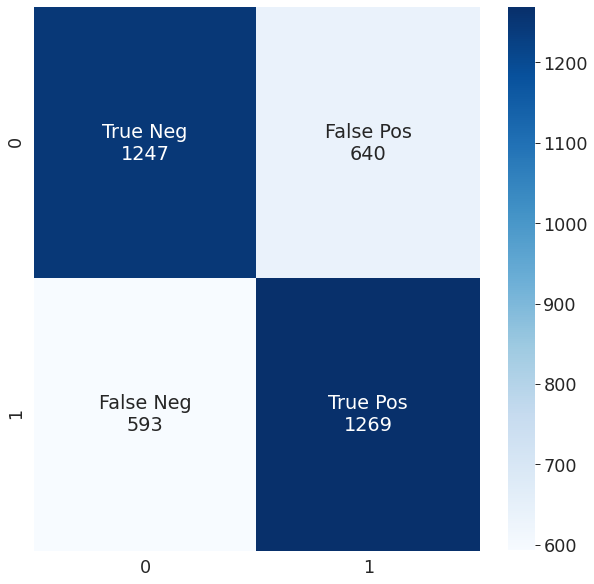

In [194]:
roc_auc_curve(y_test_us, y_pred_probs)


# confusion matrix
P = np.sum(y_test_us == 1)
N = np.sum(y_test_us == 0)
print('Positive: {0}, Negative: {1}'.format(P, N))

cm = confusion_matrix(y_test_us, Y_predicted)
print(cm)

# визуализация confusion matrix
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

In [196]:
# сравним метрики с предыдущей моделью
summary_metrics(summary,'model_us_1',y_test_us,Y_predicted,y_pred_probs)

,model_0,new_model_0,model_us_0,model_1,new_model_1,model_us_1
accuracy,0.875542,0.665718,0.678581,0.874864,0.663618,0.671112
precision,0.445652,0.223626,0.671362,0.364865,0.220620,0.664746
recall,0.022441,0.688013,0.691192,0.014778,0.678161,0.681525
f1_score,0.042731,0.337540,0.681133,0.028406,0.332930,0.673031
ROC_AUC,0.741925,0.741504,0.737270,0.737161,0.736489,0.736916


[train] F1-score = 0.74 +/- 0.00
[valid] F1-score = 0.73 +/- 0.03


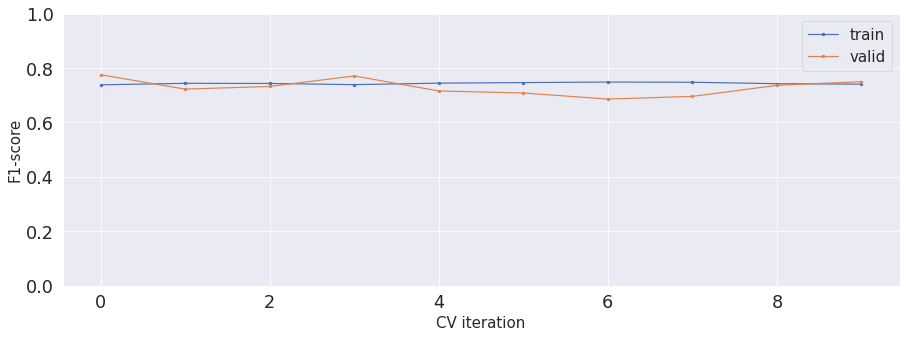

In [197]:
temp_vec = cross_validate(model_us_1, X_test_us, y_test_us, cv=10, scoring='roc_auc', return_train_score=True)
plot_cv_metrics(temp_vec)

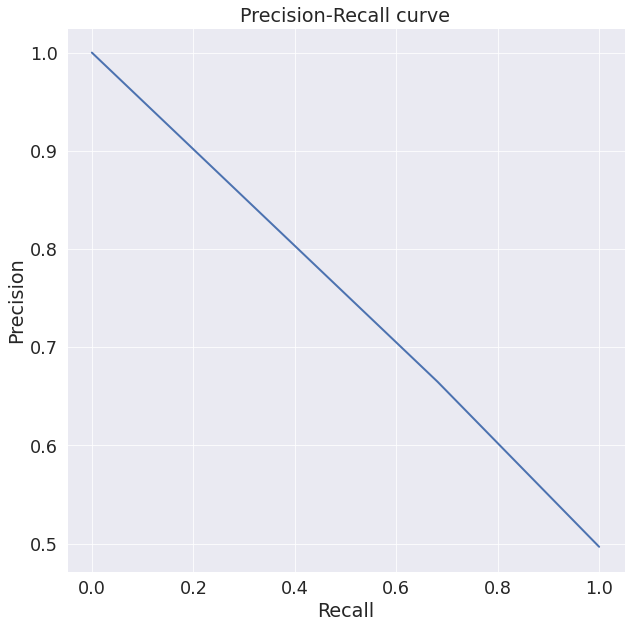

In [198]:
precisions, recalls, thresholds = precision_recall_curve(y_test_us, Y_predicted)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(recalls, precisions, linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.savefig("Precision_Recall_curve.png")
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [199]:
report = classification_report(y_test_us, Y_predicted, target_names=['Negative', 'Positive'])
print(report)

              precision    recall  f1-score   support

    Negative       0.68      0.66      0.67      1887
    Positive       0.66      0.68      0.67      1862

    accuracy                           0.67      3749
   macro avg       0.67      0.67      0.67      3749
weighted avg       0.67      0.67      0.67      3749



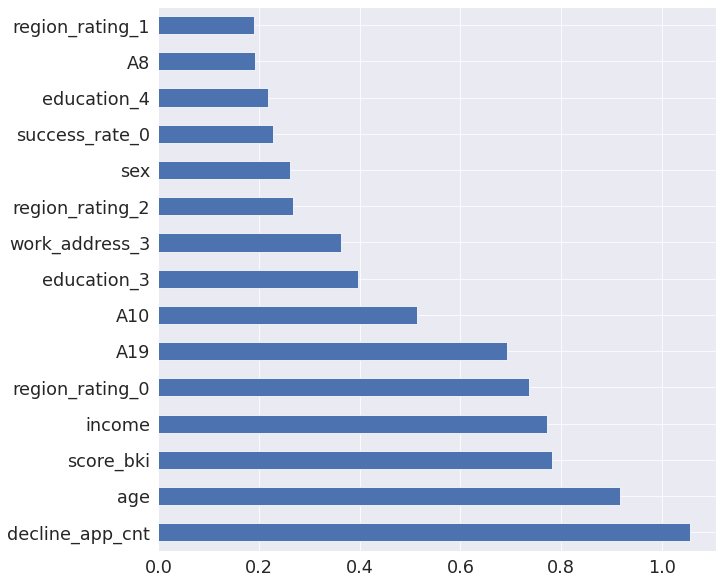

In [200]:
feat_importances = pd.Series(model_us_1.coef_.flatten(), index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')


В итоге все характеристики похуже, не будем это использовать в kaggle